<center><h1>Project Work</h1>
<b>Matteo Periani</b>, <b>Simone Mele</b>, <b>Gian Marco Baroncini</b>, and <b>Giuseppe Mantineo</b><br/>
Master's Degree in Artificial Intelligence, University of Bologna<br/>
{ matteo.periani2, simone.mele, gianmarco.baroncini, giuseppe.mantineo }@studio.unibo.it
</center>

In [1]:
# !make install
# !make download_data

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import re
import emoji


import torch


import numpy as np


import seaborn as sns


import matplotlib
import datasets
from collections import defaultdict


from src.config import Config


from src.utils import to_pandas, flatten, replace_str


from src.analysis import (
    plot_cls_distribution,
    plot_cls_counts,
    plot_cls_null_counts,
    print_n_annotations,
    print_txt_with_punctuations,
    print_n_items,
    print_mapping,
)


from src.data import (
    GroupLabelProcessor,
    is_annotation_valid,
    set_features_to_null_wrt_rules,
    white_space_fix,
    lower,
    aggregation_proposals_by_similarity,
    print_aggregation_proposals,
    filter_out_labels_with_multiple_concepts,
    split_on_and_or_slash,
    load_raw_data,
    rename_data_columns,
    split_group_labels,
    clean_data,
    constains_html_escaped_str,
    unescape_html_str,
    contains_links,
    remove_links,
    starts_with_RT_at_author,
    remove_RT_at_author,
    preprocess_post,
    preprocess_stereotype,
    preprocess_data,
    tokenize_data,
    print_tokenized_dataset,
    remove_overlapping_posts,
    aggregate_data,
)


from src.text_similarity import (
    TextSimilarity,
    show_embedding_space,
)



# keep datasets in memory if < 8 GB
datasets.config.IN_MEMORY_MAX_SIZE = 8 * 1024**3

datasets.disable_caching()
datasets.utils.disable_progress_bar()


sns.set_theme()


matplotlib.rcParams["figure.figsize"] = (20, 10)


config = Config.load_config()


print("GPU available:", torch.cuda.is_available())

GPU available: True


# Problem Description

The goal of our work is to build a model that is able to highlight biases and stereotypes, both implicit and explicit, from texts. To train our models we use SBIC corpus. The task our model must be able to solve may be divided into two sub-tasks:
1. categorical classification: 
    - the text is **offensive**
    - the offense is **intentional**
    - the text has sexual content (**sex**)
    - the offense targets a group, e.g. a minority, or an individual (**vs_group**)
    - the writer belongs to the targeted group (**in_group**)
2. free-form text generation:
    - the targetted group (**group**)
    - an explaination of the involved stereotype (**stereotype**)

# Data Analysis

In [4]:
data = load_raw_data(config)
data = rename_data_columns(data, config)

cols = data.column_names["train"]
print(cols)

['post', 'offensive', 'intentional', 'sex', 'vs_group', 'in_group', 'group_category', 'group', 'stereotype', 'sexReason', 'annotatorGender', 'annotatorMinority', 'sexPhrase', 'WorkerId', 'HITId', 'annotatorPolitics', 'annotatorRace', 'annotatorAge', 'source']


In [5]:
df = to_pandas(data)
df = df[df["split"] != "test"]
df.sample(10)

,post,offensive,intentional,sex,vs_group,in_group,group_category,group,stereotype,sexReason,annotatorGender,annotatorMinority,sexPhrase,WorkerId,HITId,annotatorPolitics,annotatorRace,annotatorAge,source,split
115924,They are so indecisive... it's so fuckin' anno...,0.5,0.66,0.0,0.0,NaN,None,None,None,None,woman,female,None,5330619308534303933,3EKTG13IZUX0D567OUX5KWOHET4MLO,mod-cons,white,35.0,t/founta,val
22607,I'm just gonna stop tagging Tristen in stuff b...,0.5,1.00,0.0,0.0,NaN,None,None,None,None,woman,"Woman, African American",None,7067515179960755087,3RQVKZ7ZRKDBRGDCAIDBMISID4I274,mod-liberal,black,30.0,t/founta,train
20991,she was the type of YouTuber who won't reply t...,0.5,0.66,0.0,0.0,NaN,None,None,None,None,man,None,None,995503448845532400,341YLJU21IT8G0U8T9H8D7IRRKT2IZ,liberal,white,35.0,t/founta,train
67202,You're a horrible parent. @jrdrury13 Call me s...,1.0,1.00,0.0,1.0,0.0,gender,women,women can't do what men can,None,woman,None,None,8789702980570783632,3QE4DGPGBR54NN307Z0TLA29WICG4Q,other,hisp,27.0,t/waseem,train
125308,"Everyone I've met, ever:: So what do you want ...",0.0,0.33,0.0,0.0,NaN,None,None,None,None,woman,None,None,3063367745612339446,3RTFSSG7T80WIH0LSW3STUQ8CNILWY,mod-liberal,black,33.0,redditMicroagressions,val
111193,"For every upvote I get on this post, I will do...",0.0,0.00,0.0,0.0,0.0,None,None,None,None,na,None,None,1558992385113521549,3TUOHPJXYHRRIBHA6F6G4OLVK1LXW0,na,na,35.0,r/Incels,train
1531,A fat bitch &gt; RT @WayneL_Jr: A strong black...,1.0,0.66,0.0,0.0,NaN,None,None,None,None,man,None,None,1558992385113521549,36FFXPMST9IMRC8TAPXKK8KFRB4OHP,libert,white,39.0,t/davidson,train
47457,Asians are really bad drivers... I'm starting ...,1.0,1.00,0.0,1.0,0.0,race,asian folks,asians can't drive,None,man,None,None,3014462452121555470,30Z7M1Q8UYE4WXDZX2YW607BYWIA8A,mod-liberal,white,38.0,r/darkjokes,train
9451,Age 17 is legal to pick up a child as long as ...,0.0,0.00,0.0,NaN,NaN,None,None,None,None,man,None,None,4587989698772014511,3EHIMLB7F7TJ6KLD388ONMUFC7JH80,liberal,white,37.0,t/founta,train
81470,"Would you like a newspaper, young lady?",0.0,0.00,0.0,NaN,NaN,None,None,None,None,woman,None,None,1869048359460155317,30F94FBDNRESDRAF6E9NS7N4WZMBTB,mod-cons,white,18.0,redditMicroagressions,train


The two sub-tasks may involve different approaches. We start by analysing classification features.

In [6]:
df_cls = df[config.classification_columns + ["split"]]

Numbers in the classification features have the following meaning (from 0. to 1.):
- **offensive**: no, maybe, yes
- **intentional**: no, probably no, probably yes, yes
- **sex**: no, maybe, yes
- **vs_group**: no, yes
- **in_group**: no, maybe, yes

The histograms belows show that the dataset is very imbalanced.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

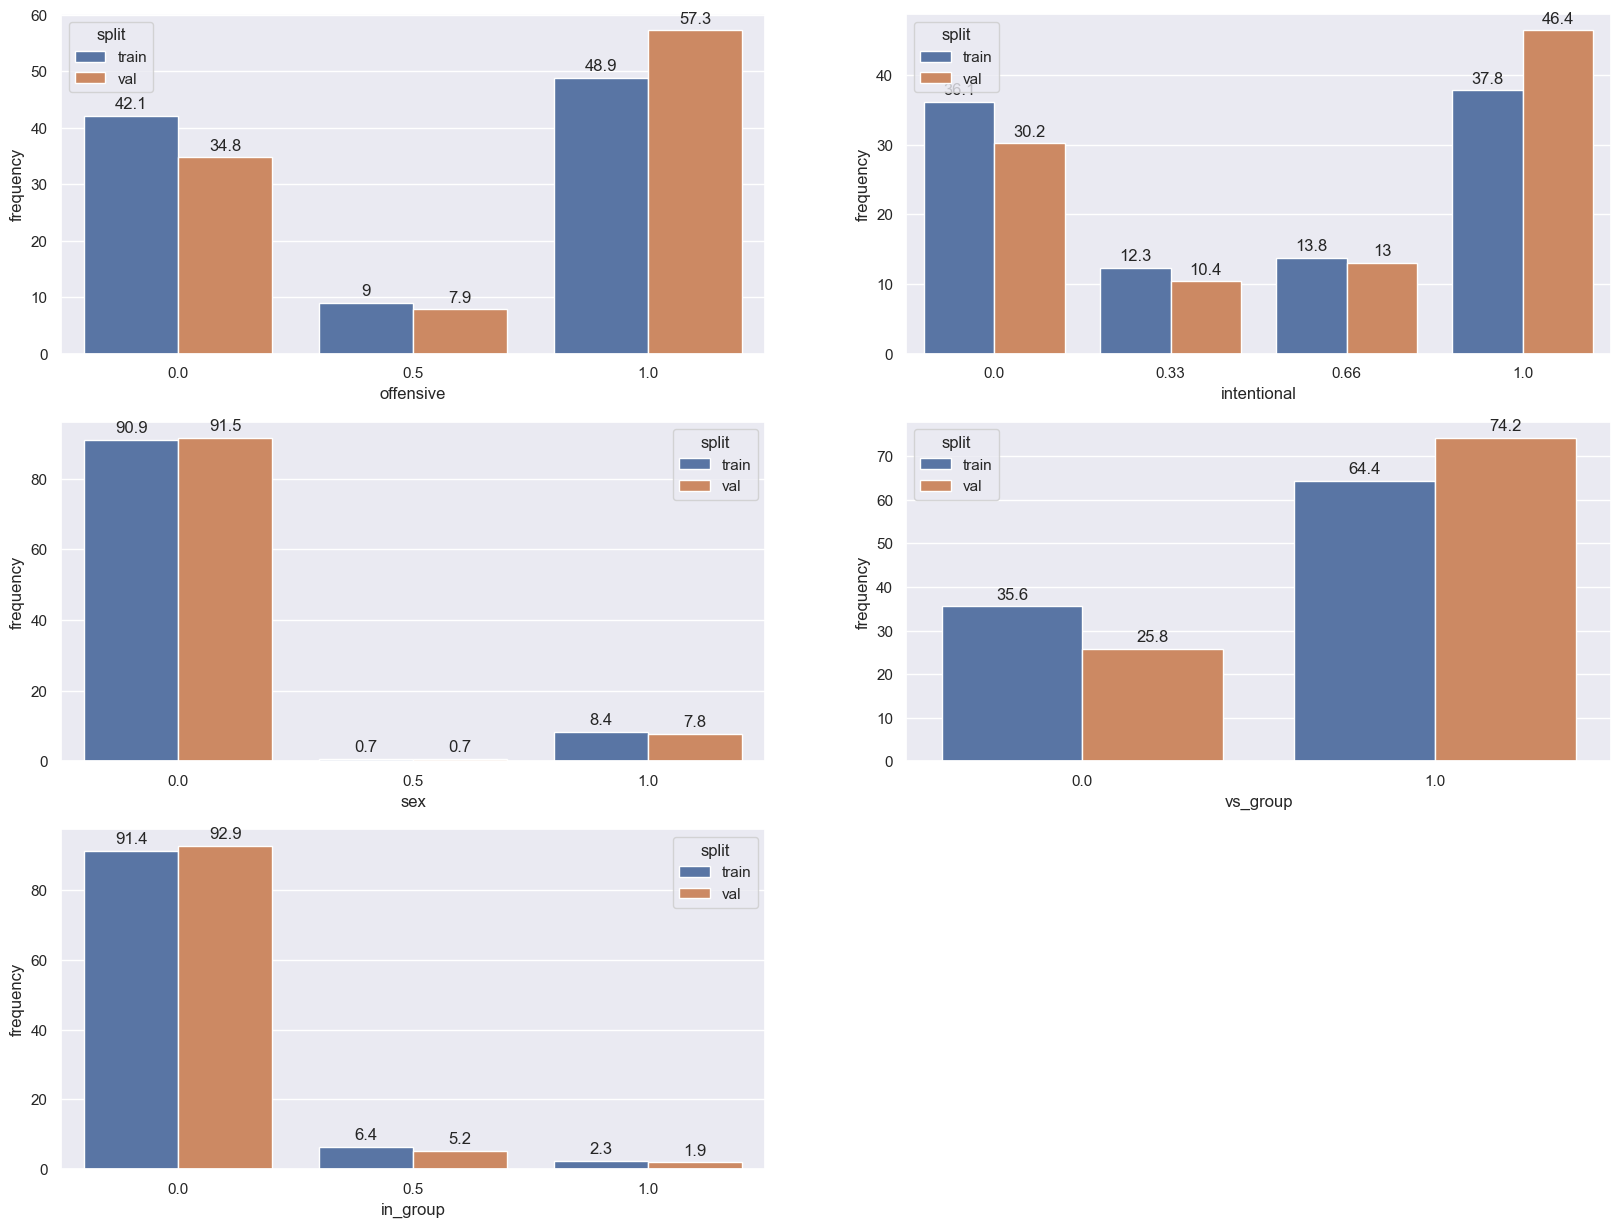

In [7]:
plot_cls_distribution(df_cls, cls_cols=config.classification_columns, type="bar")

As shown by the plots below, there are more posts annotated as intentional or sex than the ones annotated as offensive. We must investigate this issue, as the paper states that:
1. annotators indicate whether the post is offensive, whether the intent was to offend, and whether it contains lewd or sexual content.
2. if annotators indicate potential offensiveness do they answer the group implication question. Hence, `offensive => vs_group not None`.
3. if post targets a group, annotators write which one. Hence, `vs_group => group not None`.
4. for each selected group, annotators write two to four stereotypes. Hence, each group has about 2-4 stereotypes (`vs_group => stereotype not None`). 
5. annotators indicate if the writer of the post is part of one of the minority groups referenced. Hence, `vs_group => in_group not None`.

In [8]:
print_n_annotations(df_cls)

Total number of annotations: 129638
- train: 112900
- val: 16738


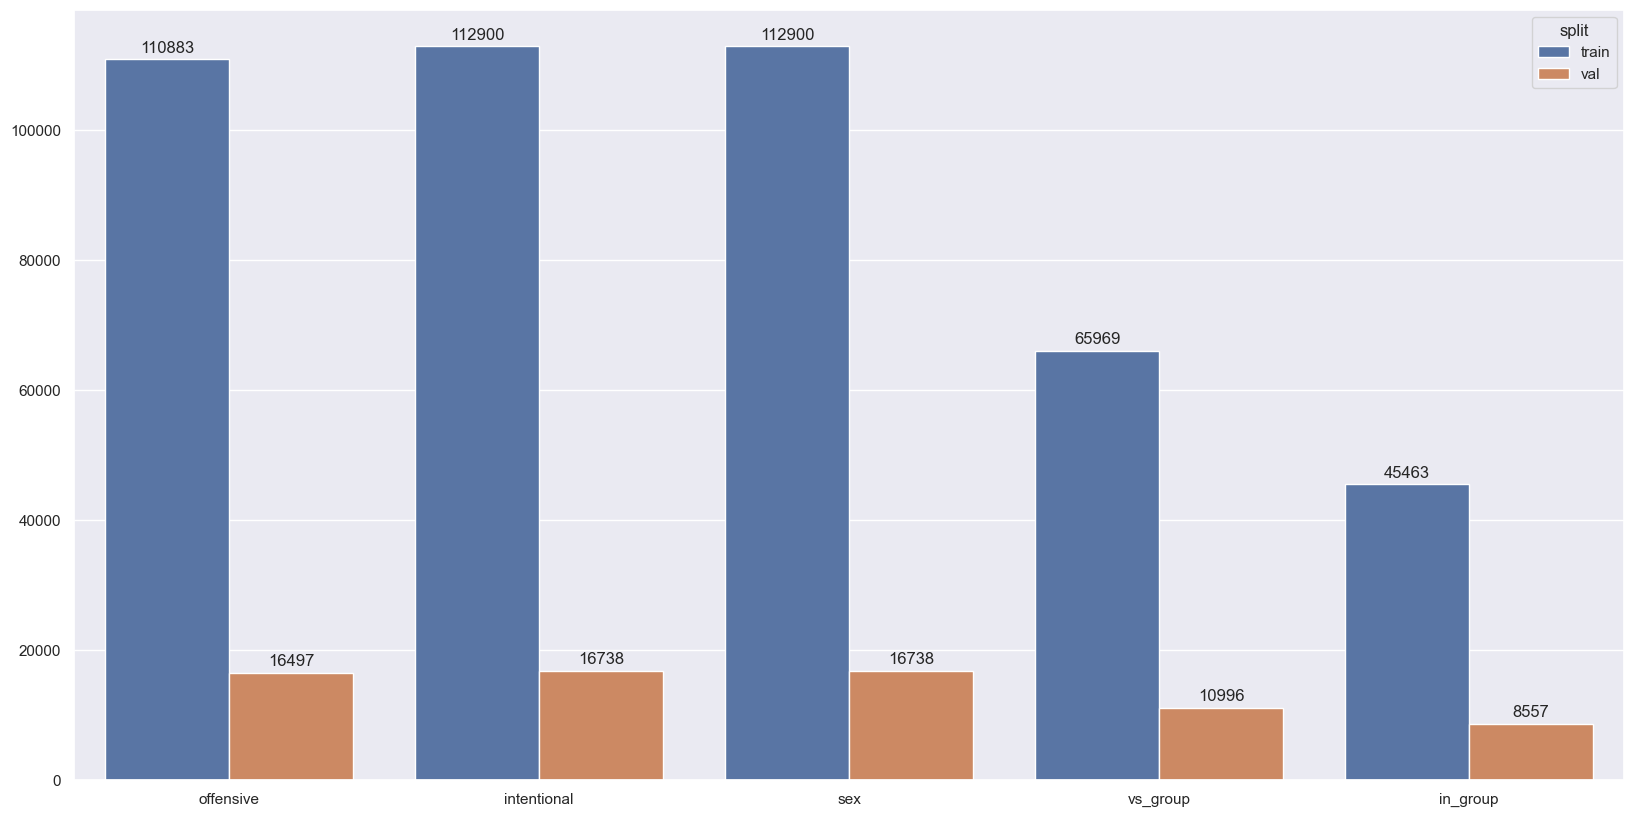

In [9]:
plot_cls_counts(df_cls, cls_cols=config.classification_columns)

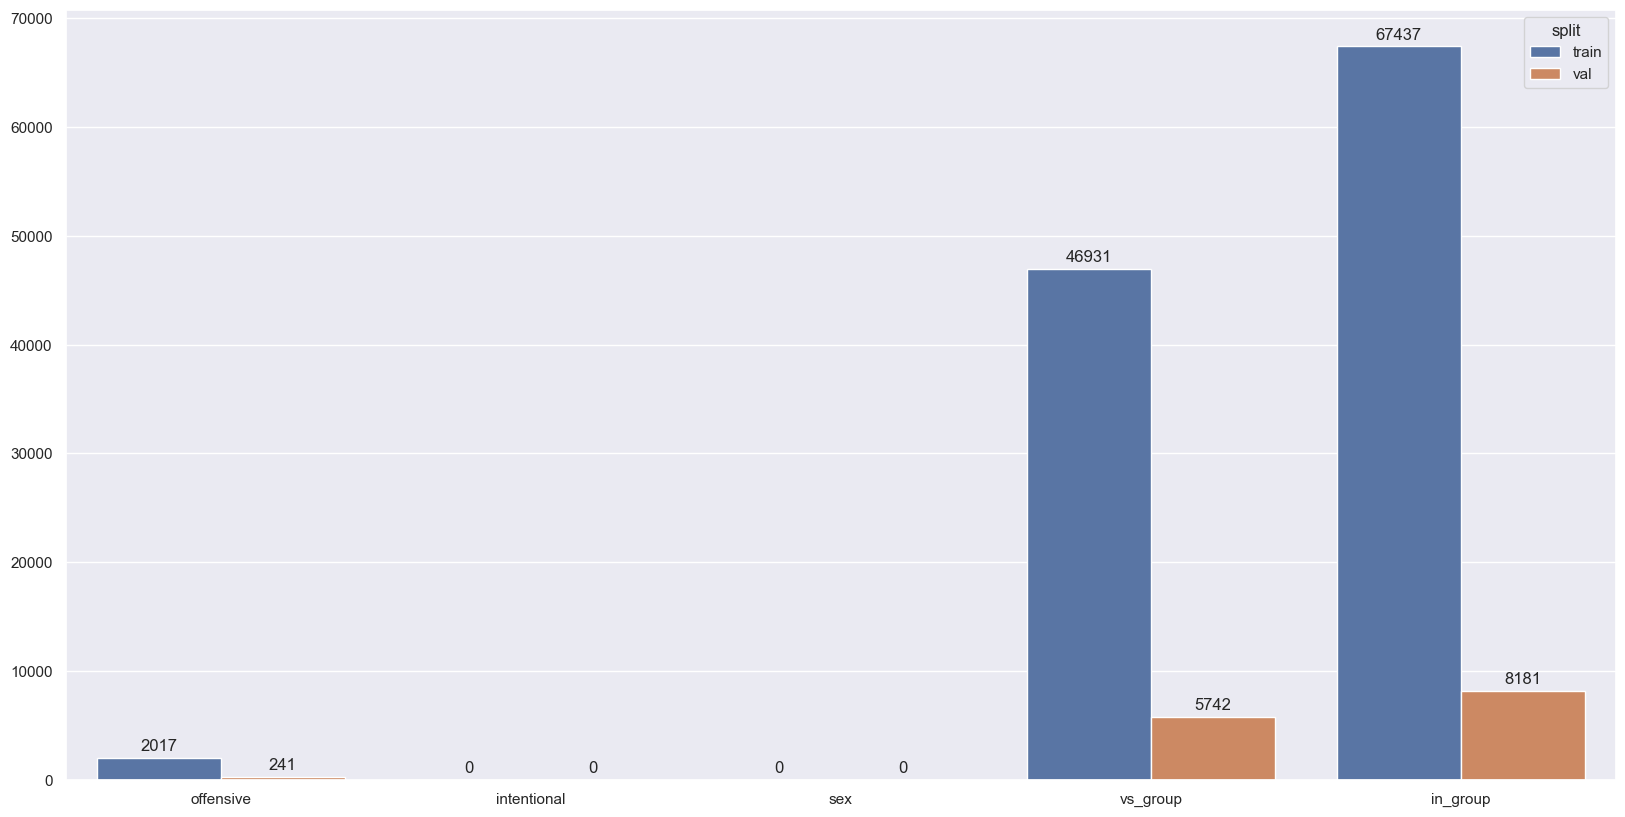

In [10]:
plot_cls_null_counts(df_cls, cls_cols=config.classification_columns)

Since wrongly annotated posts according to (1) are about 1.5% of the total posts, we just remove them from the dataset.

In [11]:
df_cls = df_cls[df_cls["offensive"].notnull()]
print_n_annotations(df_cls)

Total number of annotations: 127380
- train: 110883
- val: 16497


Now, we must ensure that `offensive => vs_group not None`.

In [12]:
df_valid = df_cls[(df_cls["offensive"] > 0.0) & (df_cls["vs_group"].notnull())]
df_non_valid = df_cls[(df_cls["offensive"] > 0.0) & (df_cls["vs_group"].isnull())]

print_n_annotations(df_valid, txt="Total number of valid annotations:")
print()
print_n_annotations(df_non_valid, txt="Total number of non valid annotations:")

Total number of valid annotations: 74971
- train: 64210
- val: 10761

Total number of non valid annotations: 0


And that `vs_group => in_group not None`. Again. since we have only 4 invalid annotations, we remove them from the dataset.

In [13]:
vs_group = (df_cls["offensive"] > 0.0) & (df_cls["vs_group"] > 0.0)
df_valid = df_cls[vs_group & (df_cls["in_group"].notnull())]
df_non_valid = df_cls[vs_group & (df_cls["in_group"].isnull())]

print_n_annotations(df_valid, txt="Total number of valid annotations:")
print()
print_n_annotations(df_non_valid, txt="Total number of non valid annotations:")

df_cls = df_valid

Total number of valid annotations: 50505
- train: 42361
- val: 8144

Total number of non valid annotations: 4
- train: 4


In [14]:
offensive_not_null = df["offensive"].notnull()
df = df[offensive_not_null]

offensive = df["offensive"] > 0.0
group_not_null = df["vs_group"].notnull()
df = df[(~offensive) | (offensive & group_not_null)]

offensive = df["offensive"] > 0.0
vs_group = offensive & (df["vs_group"] > 0.0)
in_group_not_null = df["in_group"].notnull()
df = df[(~vs_group) | (vs_group & in_group_not_null)].reset_index(drop=True)

print_n_annotations(df)

Total number of annotations: 127376
- train: 110879
- val: 16497


We ensure that `vs_group => (group not None, stereotype not None)`.

In [15]:
vs_group = (df["offensive"] > 0.0) & (df["vs_group"] > 0.0)
df_valid = df[vs_group & (df["group"].notnull())]
df_non_valid = df[vs_group & (df["group"].isnull() | df["stereotype"].isnull())]

print_n_annotations(df_valid, txt="Total number of valid annotations:")
print()
print_n_annotations(df_non_valid, txt="Total number of non valid annotations:")

Total number of valid annotations: 50505
- train: 42361
- val: 8144

Total number of non valid annotations: 938
- train: 783
- val: 155


It's time to filter out invalid annotations from the dataset and to set to None the features according to the rules stated above. 

In [16]:
print("Number of annotations before removing invalid annotations:")
print(data.num_rows)

data = data.filter(is_annotation_valid)

print("Number of annotations after removing invalid annotations:")
print(data.num_rows)
print()

print("Setting target features to None according to annotation rules...")
data = data.map(set_features_to_null_wrt_rules)

Number of annotations before removing invalid annotations:
{'train': 112900, 'val': 16738, 'test': 17501}


Number of annotations after removing invalid annotations:
{'train': 110096, 'val': 16342, 'test': 17084}

Setting target features to None according to annotation rules...


## Group labels analysis and reduction

For each post, our model has to predict a set of targeted groups. So, we cannot solve the task as a classic classification problem, but we may approach it as a generative task. Nevertheless, we can try to reduce the space of generated groups, by semantically aggregating such labels. We think that diversity is not a good thing we want our network to have for this task. Hence, reducing the space of group labels will increase data quality and, consequently, network accuracy.

First of all, we visualize all the groups divided by category.

In [17]:
df = to_pandas(data)
df_groups = df[df["group"].notnull()]

n_groups = len(df["group"].unique())

print("Number of unique groups:", n_groups)
print()


groups_by_category = df_groups.groupby("group_category")["group"].apply(set)

for category, pieces in groups_by_category.items():
    print(category)
    print(list(pieces))
    print()

Number of unique groups: 1404

body
['skinny men', 'Red-haired persons', 'virgins', 'Millennials', 'deaf folks', 'teen moms', 'fraternity members', 'anorexic', 'overweight/fat folks, ugly folks', 'young folks', 'minor girls', 'uncles', 'woman with small breasts', 'skinny folks', 'breast size', 'Parents', 'red-haired people', 'overweight/fat folks, ugly folks, "incels" or celibate not by choice', 'Attractive folks', 'millennials', 'little people', 'ugly folks, Good looking folks', 'Young people', 'blonde women', 'Millenials/Generation Z', 'Young kids', 'teenage girls', 'kids', 'unwed non parents', 'old folks', 'Blondes', 'pedophiles', 'teenagers', 'infant', 'sexual women', 'ugly folks', 'younger genereration', 'cancer patients', 'shorts folks', 'old folks, seniors', 'babies', 'bald folks', 'pregnant folks, parents', 'emo', 'Young boys', 'young children', 'young girls', 'siblings', 'old folks, overweight/fat folks', 'blondes', '18 year olds', 'orphans', 'high school students', 'young peo

In [18]:
pieces = flatten(df_groups["group"].apply(split_group_labels))
pieces = [lower(group) for group in pieces]
print("Number of unique groups:", np.unique(pieces).size)

Number of unique groups: 1125


We have slash-separated labels that can be splitted in a set of labels.

We want to reduce the number of labels according to their semantic meaning. As an example, `blacks` and `black people` represent the same concept. Therefore, we keep only one of them. We try to cluster labels in a semi-automated manner, exploiting a text-embedding model. According to [MTEB](https://arxiv.org/abs/2210.07316), the best embedding model for text similarity is [UAE-Large-V1](https://huggingface.co/WhereIsAI/UAE-Large-V1).

In [19]:
text_similarity = TextSimilarity(config.embedding_model)
group_lbl_processor = GroupLabelProcessor(pieces)
group_lbl_processor.remove_double_spaces()
group_labels = group_lbl_processor.label_list()
print("Number of unique groups:", len(group_labels))

Number of unique groups: 1001


In [20]:
embedding_space = text_similarity.generate_embeddings(group_labels)
similarity_matrix = text_similarity.compute_pairwise_similarity_matrix(
    embedding_vectors=embedding_space
)

The (low-dimensional projection of the) embedding space shows some clusters. 

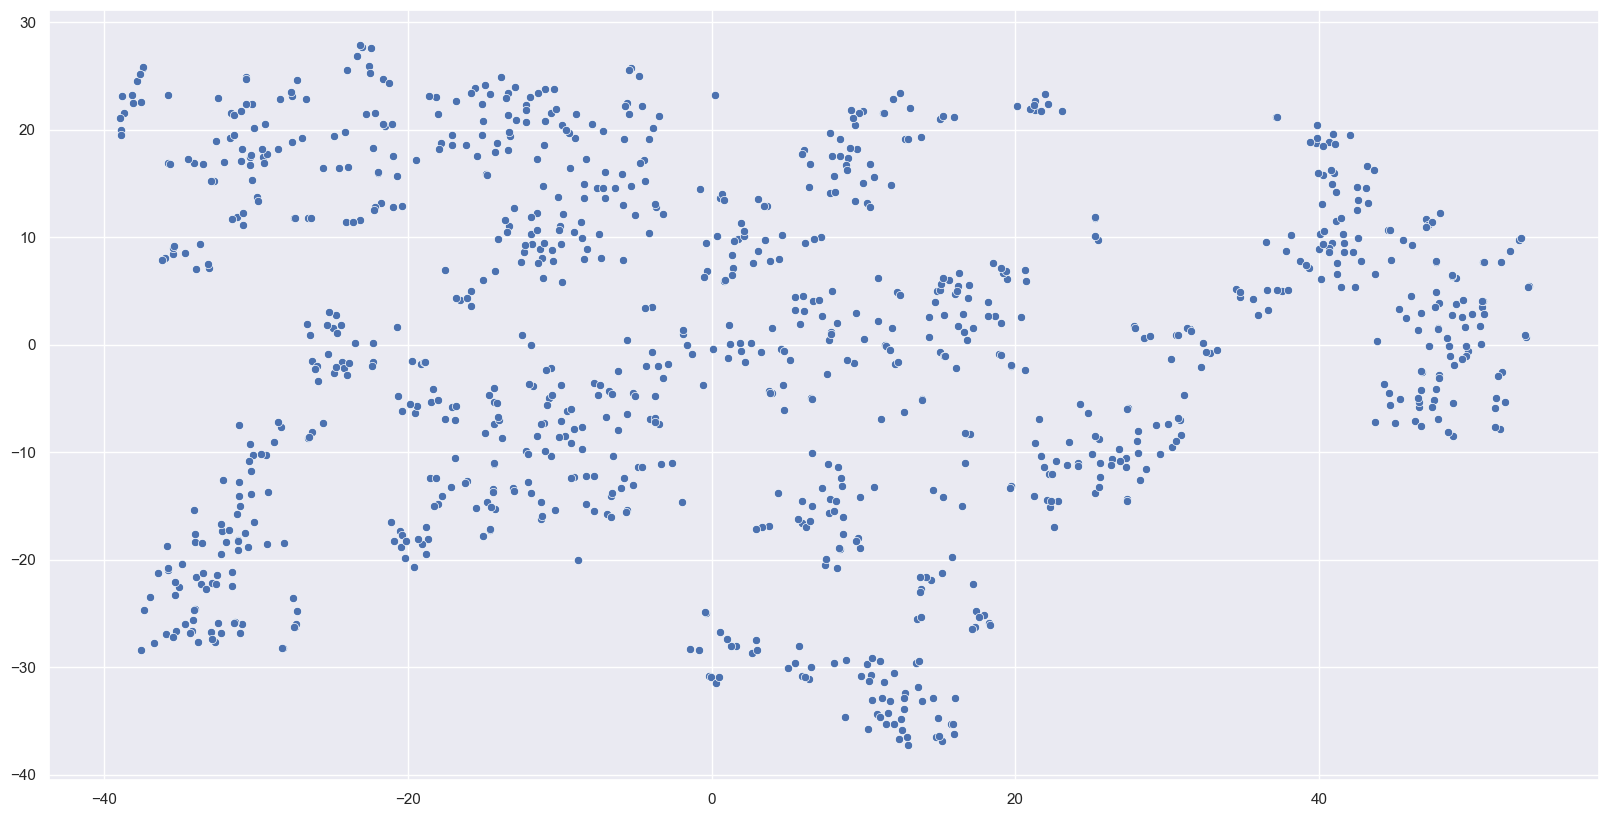

In [21]:
show_embedding_space(embedding_space, pca_components=20)

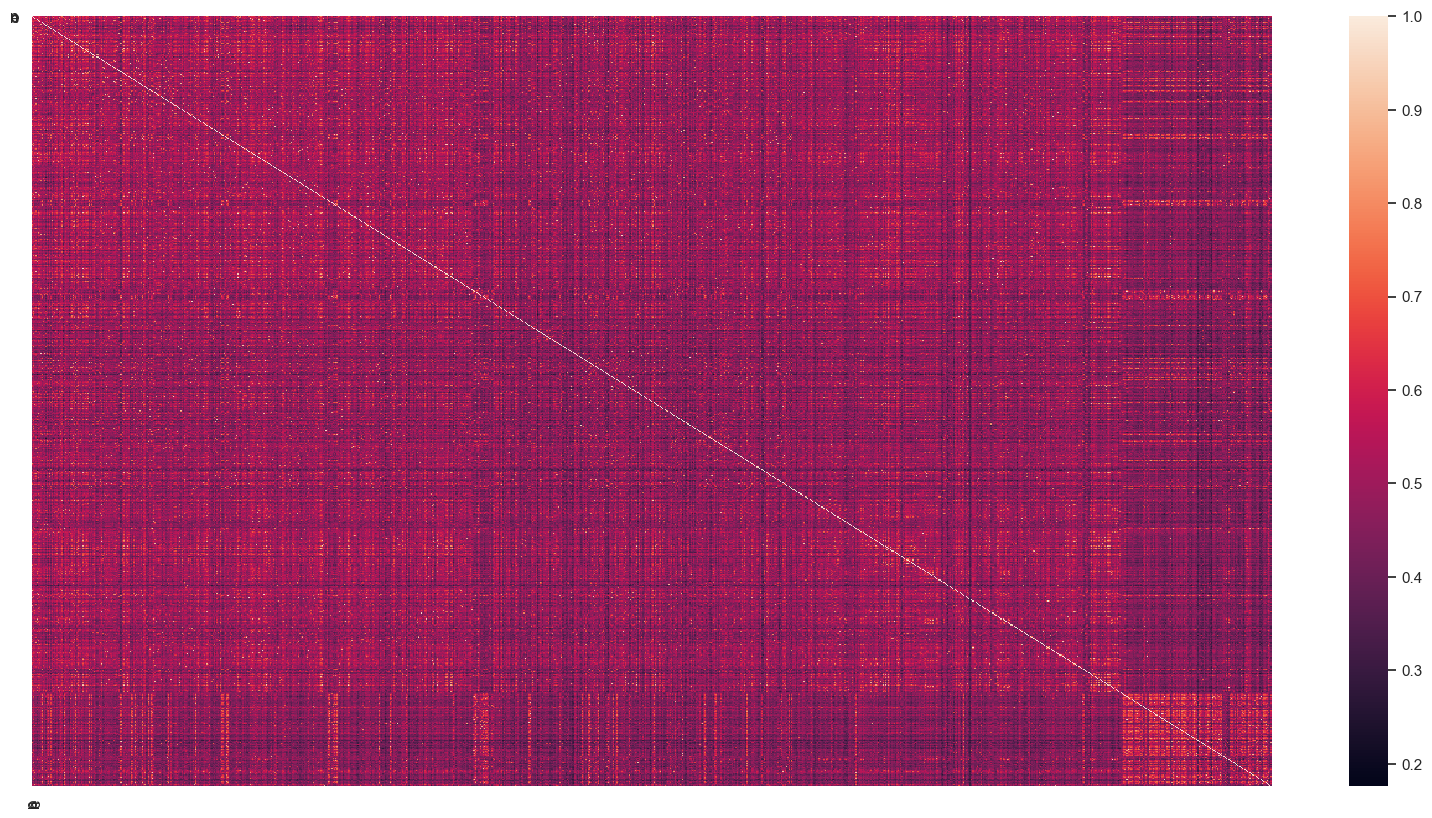

In [22]:
ax = sns.heatmap(similarity_matrix, xticklabels="none", yticklabels="none")

Most of the labels have very low similarity. Let's set a threshold.

<Axes: >

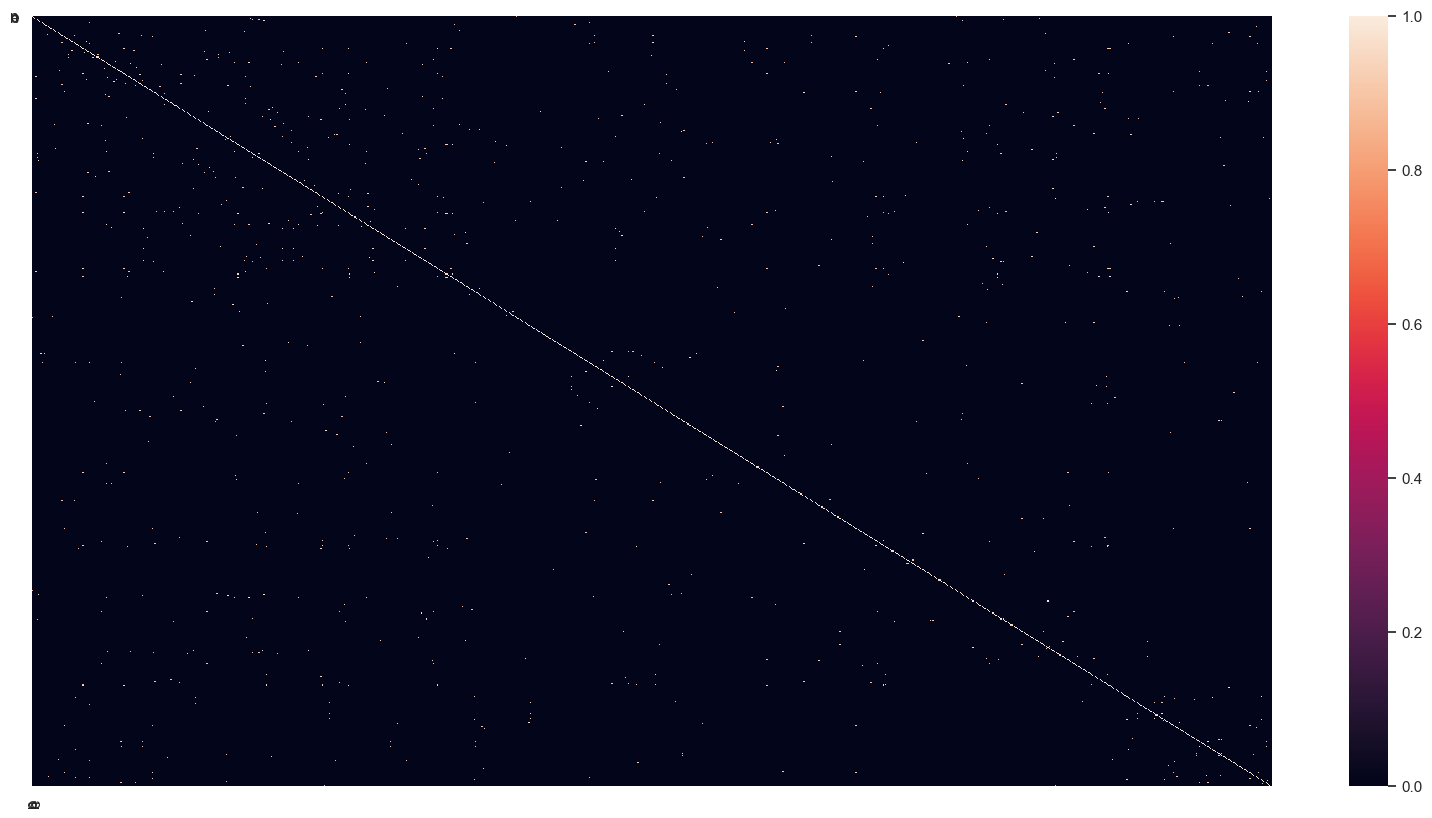

In [23]:
threshold = 0.88
sns.heatmap(
    similarity_matrix * (similarity_matrix > threshold),
    xticklabels="none",
    yticklabels="none",
)

In [24]:
aggregation_proposals = aggregation_proposals_by_similarity(
    group_labels, similarity_matrix, threshold=threshold
)
print_aggregation_proposals(aggregation_proposals, group_lbl_processor.groups_count)

black folks (18046): {'blacks', 'light skinned black folks'}
jewish folks (5716): {'jewish folk', 'jewish people'}
muslim folks (2608): {'islamic folks', 'islamic people', 'muslims', 'muslim'}
gay men (1893): {'gay folks', 'gay people', 'homosexual men'}
asian folks (1693): {'asians', 'asian people'}
physically disabled folks (1344): {'disabled people', 'disabled folks', 'the handicapped'}
assault victims (1016): {'sex assault victims', 'sexual assault victims'}
mentally disabled folks (958): {'disabled people', 'disabled folks'}
folks with mental illness/disorder (670): {'folks with physical illness/disorder'}
mass shooting victims (658): {'shooting victims'}
native american/first nation folks (557): {'indigenous folks'}
overweight/fat folks (505): {'fat people', 'fat folks'}
arabic folks (483): {'arab folks'}
trans men (413): {'cis men'}
feminists (410): {'feminist', 'feminist women'}
folks with physical illness/disorder (357): {'folks with mental illness/disorder'}
africans (300): {

At a first sight, results seem very good. Let's start by inspecting groups that have punctuations.

In [25]:
print_txt_with_punctuations(group_labels)

Punctuation: /
eastern/indian people
holocaust survivors/jews
priests/nuns
german people/jewish people
indian/pakistani people
pakistan/indian people
rednecks/south region in the us
folks with mental illness/disorder
overweight/fat folks
middle eastern / arabic people
latino/latina folks
folks with physical illness/disorder
bullimacs/anorexics
gypsies/ romani
millenials/generation z
gay/lesbians
everyone/parents/children
people who self-harm/are suicidal
members of the irish repulbican army and/or the ira political group in ireland.
rural/ country folks
africa/middle east
any racial/ethnic minority in america
native american/first nation folks
independents/libertarians
syrians/russians
sexual assault/rape victims
brown/asian people
kidnap/violence/murder victims
southerners/ rednecks
middle east/africa
victims of 9/11

Punctuation: -
alt-right
middle-eastern folks
basically all non-white women
non-christians
self-harming people
red-haired persons
non-binary people
pro-life advocates
no

From the analysis above, we have that:
1. text between parenthesis is irrelevant. We remove it.
2. `? ' " .` are irrelevant. We remove them, paying attention to keep `'s 't`.
3. `-` can be replaced by space.

In [26]:
punct_substitution_map = {
    r"\(.*\)": " ",
    r'[\?".]': " ",
    r"'(?![st])": " ",
    r"\s*-\s*": " ",
    r"\band\s*/\s*or\b": "or",
}
group_lbl_processor.rename_groups(punct_substitution_map)
group_lbl_processor.remove_double_spaces()
group_labels = group_lbl_processor.label_list()

print("Number of unique groups:", len(group_labels))
print()
print_txt_with_punctuations(group_labels)

Number of unique groups: 981

Punctuation: /
people who self harm/are suicidal
eastern/indian people
holocaust survivors/jews
priests/nuns
german people/jewish people
indian/pakistani people
pakistan/indian people
rednecks/south region in the us
folks with mental illness/disorder
overweight/fat folks
middle eastern / arabic people
latino/latina folks
folks with physical illness/disorder
bullimacs/anorexics
gypsies/ romani
millenials/generation z
gay/lesbians
everyone/parents/children
rural/ country folks
africa/middle east
any racial/ethnic minority in america
native american/first nation folks
independents/libertarians
syrians/russians
sexual assault/rape victims
brown/asian people
kidnap/violence/murder victims
southerners/ rednecks
middle east/africa
victims of 9/11

Punctuation: '
anyone that isn't white
germans and anyone that's sensitive about the hol
women's who ve had abortions
gypsy's
folks with alzheimer's
jehova's witnesses
parkinson's
jehovah's witnesses
people who's father

Morover, to reduce labels to inspect by hand, let's craft some deterministic rules based on aggregations found:
1. people, persons and folks are used interchangeably. Hence, we change folk(s) into people.
2. children and kids are used interchangeably. We keep children.
3. illness and disorder are used interchangeably. We keep illness.
4. fat and overweight are used interchangeably. We keep fat.

Labels containing a slash or an and/or conjunction may contain multiple concepts. Therefore, we ignore them at the moment.

In [27]:
substitution_map = {
    r"\b(?:(?:illness\s*/\s*disorders?)|(?:disorders?\s*/\s*illness)|(?:disorders?))\b": "illness",
    r"\b(?:(?:fat\s*/\s*overweight)|(?:overweight\s*/\s*fat)|(?:overweight))\b": "fat",
}
group_lbl_processor.rename_groups(substitution_map)

substitution_map = {
    r"\b(folks?)|(persons?)\b": "people",
    r"\bkids\b": "children",
}
group_labels = group_lbl_processor.label_list()
single_concept_labels = filter_out_labels_with_multiple_concepts(group_labels)
group_lbl_processor.rename_groups(substitution_map, groups=single_concept_labels)

group_labels = group_lbl_processor.label_list()
single_concept_labels = filter_out_labels_with_multiple_concepts(group_labels)
print("Number of unique groups:", len(group_labels))
print("Number of unique groups w/o slash, and, or:", len(single_concept_labels))

Number of unique groups: 926
Number of unique groups w/o slash, and, or: 881


We know that most of the nationalities have the suffix `an`. Therefore, we can hardcode such rules.

In [28]:
aggregation_preferences = defaultdict(list)
label_set = set(group_labels)

for lbl in single_concept_labels:
    match = re.search(r"(.+)n people", lbl)
    if match is not None:
        nation = match.group(1)
        nationality = nation + "n"

        if nation in label_set:
            aggregation_preferences[lbl].append(nation)
        if nationality in label_set:
            aggregation_preferences[lbl].append(nationality)

print_aggregation_proposals(aggregation_preferences, group_lbl_processor.groups_count)

asian people (1695): ['asia', 'asian']
african people (200): ['africa', 'african']
mexican people (95): ['mexican']
indian people (95): ['india', 'indian']
ethiopian people (85): ['ethiopia', 'ethiopian']
middle eastern people (34): ['middle eastern']
syrian people (22): ['syria', 'syrian']
german people (14): ['german']
russian people (12): ['russia', 'russian']
saudi arabian people (10): ['saudi arabia']
nigerian people (9): ['nigeria']
afghan people (8): ['afghan']
korean people (8): ['korea']
italian people (6): ['italian']
arabian people (4): ['arabian']
jamaican people (4): ['jamaica', 'jamaican']
pagan people (3): ['pagan']
malaysian people (2): ['malaysia']
pakistan people (2): ['pakistan']
somalian people (2): ['somalia', 'somalian']
cambodian people (2): ['cambodia']
palestinian people (2): ['palestinian']
egyptian people (2): ['egyptian']


Let's inspect groups ending with term `people`.

In [29]:
similarity_matrix = text_similarity.compute_pairwise_similarity_matrix(
    single_concept_labels
)
aggregation_proposals = aggregation_proposals_by_similarity(
    single_concept_labels, similarity_matrix, threshold=threshold
)
people_agg_proposals = {
    group: agg
    for group, agg in aggregation_proposals.items()
    if group.endswith("people")
}

print_aggregation_proposals(people_agg_proposals, group_lbl_processor.groups_count)

black people (18046): {'blacks', 'people of african descent', 'light skinned black people', 'any black people'}
jewish people (5726): {'jews', 'jewish'}
muslim people (2608): {'islamic people', 'muslims', 'muslim'}
asian people (1695): {'asians', 'asian'}
physically disabled people (1344): {'disabled people', 'the handicapped'}
mentally disabled people (958): {'disabled people'}
arabic people (483): {'arab people'}
white people (291): {'whites'}
african people (200): {'people of african descent', 'black africans', 'africans'}
mexican people (95): {'mexicans'}
indian people (95): {'people from india'}
ethiopian people (85): {'ethiopians', 'ethiopian'}
non white people (39): {'non whites', 'american non whites', 'all non whites', 'any non white people', 'non white', 'all non white people'}
middle eastern people (34): {'middle easterners', 'people from the middle east', 'middle eastern', 'middle easterns'}
irish people (28): {'irishmen'}
young people (25): {'younger people'}
syrian people

Before automatically merging all groups, we want to prevent some aggregation to happens and to force other ones.

In [30]:
aggregation_blacklist = [
    ("black people", "people of african descent"),
    ("black people", "light skinned black people"),
    ("physically disabled people", "disabled people"),
    ("mentally disabled people", "disabled people"),
    ("the handicapped", "disabled people"),
    ("gay people", "homosexual people"),
    ("gay people", "homosexuals"),
    ("gay people", "queer people"),
    ("homosexual people", "homosexual men"),
    ("gays", "homosexuals"),
    ("gays", "homosexuals"),
    ("homosexual men", "homosexuals"),
    ("lgbtq+ people", "queer people"),
    ("interracial people", "interracial couples"),
    ("gendered people", "gender fluid people"),
]


aggregation_preferences.update(
    {
        "american southern people": ["southern people"],
        "physically disabled people": ["the handicapped"],
    }
)

We have some labels containing the fact and others where the fact is followed by `victims` or `survivors`, e.g. `sex assault victims`. Let's aggregate them.

In [31]:
victims_aggregates = defaultdict(list)

for lbl in single_concept_labels:
    match = re.match(r"(.+) \b(survivor|victim)s?\s*$", lbl)
    if match is not None:
        fact = match.group(1)
        dest_group = f"{fact} {match.group(2)}s"

        if fact in label_set:
            victims_aggregates[dest_group].append(fact)
        if dest_group != lbl:
            victims_aggregates[dest_group].append(lbl)

victims_aggregates.pop("homeless victims")
aggregation_preferences.update(victims_aggregates)
print_aggregation_proposals(victims_aggregates, group_lbl_processor.groups_count)

holocaust victims (272): ['holocaust']
rape victims (144): ['rape', 'rape', 'rape victim']
sexual assault victims (80): ['sexual assault', 'sexual assault', 'sexual assault victim']
pedophilia victims (27): ['pedophilia']
suicide victims (21): ['suicide']
holocaust survivors (21): ['holocaust']
incest victims (19): ['incest']
domestic abuse victims (10): ['domestic abuse']
child murder victims (4): ['child murder']
kidnap victims (0): ['kidnap victim']
jewish victims (2): ['jewish']
child rape victims (35): ['child rape victim']
tragedy victims (1): ['tragedy victim']
sexual assault survivors (1): ['sexual assault']
mass accident victims (1): ['mass accident']
miscarriage survivors (1): ['miscarriage']
police shooting victims (0): ['police shooting victim']
miscarriage victims (1): ['miscarriage']
assassination victims (1): ['assassination victim']


Now, let's inspect remaining labels.

In [32]:
remaining_agg_proposals = {
    group: agg
    for group, agg in aggregation_proposals.items()
    if not group in people_agg_proposals
}

print_aggregation_proposals(remaining_agg_proposals, group_lbl_processor.groups_count)

gay men (1893): {'gay people', 'homosexual men'}
assault victims (1016): {'sex assault victims', 'sexual assault victims'}
mass shooting victims (658): {'shooting victims'}
trans men (413): {'cis men'}
feminists (410): {'feminist', 'feminist women'}
people with physical illness (357): {'sick people'}
africans (300): {'people of african descent', 'black africans', 'african people', 'african'}
holocaust victims (272): {'holocaust survivors', 'holocaust victimes'}
children (257): {'young children'}
ethiopians (215): {'ethiopian people', 'ethiopian'}
rape victims (144): {'rape victim', 'sex assault victims', 'sexual assault victims'}
people of color (124): {'people of different races'}
non whites (99): {'american non whites', 'all non whites', 'any non white people', 'non white people', 'nonwhite', 'non white', 'any non white', 'all non white people'}
sexual assault victims (80): {'child sexual assault victims', 'sex abuse victims', 'sexual assault survivors', 'sexual assault victim', 'vic

In [33]:
aggregation_blacklist.extend(
    [
        ("assault victims", "sexual assault victims"),
        ("assault victims", "sex assault victims"),
        ("sexual assault victims", "child sexual assault victims"),
        ("sex assault victims", "child sexual assault victims"),
        ("sex abuse victims", "child sexual abuse victims"),
        ("sex abuse victims", "victims of child sexual abuse"),
        ("abuse victims", "domestic abuse victims"),
        ("abuse victims", "sex abuse victims"),
        ("abuse victims", "child abuse victims"),
        ("straight white men", "white men"),
        ("straight white men", "white guys"),
        ("minorities", "racial minorities"),
        ("minorities in general", "racial minorities"),
        ("minority", "racial minorities"),
        ("minority groups", "racial minorities"),
        ("minority people", "racial minorities"),
        ("all minorities", "all racial minorities"),
        ("accident victims", "car accident victims"),
        ("accident victims", "auto accident victims"),
        ("accident victims", "car crash victims"),
        ("all colored races", "all races"),
        ("people of color", "people of different races"),
        ("trans men", "cis men"),
        ("refugees", "syrian refugees"),
        ("murder victims", "murder victim families"),
        ("molestation victims", "child molestation victims"),
        ("people of different races", "people of color"),
        ("american non whites", "non americans"),
        ("non europeans", "non americans"),
    ]
)


aggregation_preferences.update(
    {
        "black people": ["people of color"],
        "women with small breasts": ["woman with small breasts"],
    }
)

In [34]:
preferences = {
    group: aggregation_preferences.pop(group, [])
    for group in people_agg_proposals.keys()
}
preferences.update(aggregation_preferences)
group_lbl_processor.aggregate(aggregation_proposals, aggregation_blacklist, preferences)

group_labels = group_lbl_processor.label_list()
single_concept_labels = filter_out_labels_with_multiple_concepts(group_labels)

print("Number of unique groups:", len(group_labels))
print("Number of unique groups w/o slash, and, or:", len(single_concept_labels))

Number of unique groups: 632
Number of unique groups w/o slash, and, or: 587


It's time to handle groups that have a slash or an and/or conjuction. It's very likely that they are a combination of at least two groups. Therefore, we try to divide and extract these labels.

In [35]:
slash_and_or_labels = np.setdiff1d(group_labels, single_concept_labels).tolist()
label_space = [
    lower(white_space_fix(replace_str(label, punct_substitution_map)))
    for label in group_lbl_processor.processed_labels
]
label_space = np.setdiff1d(label_space, slash_and_or_labels).tolist()
embedding_space = text_similarity.generate_embeddings(label_space)

split_map = split_on_and_or_slash(slash_and_or_labels)

Initially, we split the labels and retain the resulting groups if each group is one word long. We compute similiarity of these groups with already observed labels in order to aggregate them.

In [36]:
most_similar = text_similarity.retrieve_n_most_similar(
    queries=flatten(split_map.values()),
    documents=label_space,
    documents_embeddings=embedding_space,
    n=1,
)
split_map = group_lbl_processor.map_split_if_all_groups_are_one_word_longs(
    split_map, most_similar, threshold, verbose=True
)

bullimacs/anorexics --> ['bullimacs', 'anorexics']
   bullimacs ('furry', 0.57818216) --> bullimacs
   anorexics ('anorexics', 1.0000002) --> anorexic people

everyone/parents/children --> ['everyone', 'parents', 'children']
   everyone ('everyone', 1.0000004) --> everyone
   parents ('parents', 1.0) --> parents
   children ('children', 1.0) --> children

gay/lesbians --> ['gay', 'lesbians']
   gay ('lgbt', 0.8647851) --> gay
   lesbians ('lesbian women', 0.94585645) --> lesbian women

girls and boys --> ['girls ', ' boys']
   girls  ('girls', 1.0000001) --> girls
    boys ('boys', 1.0) --> young boys

gypsies/ romani --> ['gypsies', ' romani']
   gypsies ('gypsies', 1.0000001) --> gypsies
    romani ('romani people', 0.92928934) --> romani people

independents/libertarians --> ['independents', 'libertarians']
   independents ('minority groups', 0.62923884) --> independents
   libertarians ('liberals', 0.74374115) --> libertarians

priests/nuns --> ['priests', 'nuns']
   priests ('prie

Then, we try to build groups according to four different strategies:
1. we take each group as is.
2. we take the words at the end of the original label and append them to each resulting group.
3. we take the words at the beginning of the original label and prepend them to each resulting group.
4. we combine points 3 and 4.
Subsequently, for each group we keep the best strategy according to the similarity with the already observed labels. If all the obtained groups have a similarity score higher than the threshold, we apply the spli and map rules.

In [37]:
def print_label_to_groups_mapping(
    label, best_alternatives, sim_groups, sim_scores, dest_groups
):
    print(label)
    for best_alternative, sim_group, sim_score, dest_group in zip(
        best_alternatives, sim_groups, sim_scores, dest_groups
    ):
        print(
            "-->",
            best_alternative,
            (sim_group, sim_score),
            "-->",
            dest_group,
        )
    print("-" * 30)

In [38]:
slash_and_or_labels = np.setdiff1d(
    slash_and_or_labels, list(group_lbl_processor.label_to_groups_map.keys())
).tolist()

for label, pieces in split_map.copy().items():
    groups = []
    groups.append(pieces)

    # append words at the end to each group
    # separate the first word of last group from all the rest
    match = re.search(r"(\w+)(.*)$", pieces[-1])
    last_group = match.group(1).strip()
    words_at_end = match.group(2).strip()
    pieces_ = pieces.copy()
    pieces_[-1] = last_group
    groups.append([f"{group.strip()} {words_at_end}".strip() for group in pieces_])

    # prepend words at the beginning to each group
    # separate the last word of first group from all the rest
    match = re.search(r"(.*\b)(\w+)\s*$", pieces[0])
    words_at_beginning = match.group(1).strip()
    first_group = match.group(2).strip()
    pieces_ = pieces.copy()
    pieces_[0] = first_group
    groups.append(
        [f"{words_at_beginning} {group.strip()}".strip() for group in pieces_]
    )

    # prepend words at the beginning and append words at the end to each group
    pieces_ = pieces.copy()
    pieces_[0] = first_group
    pieces_[-1] = last_group
    groups.append(
        [
            f"{words_at_beginning} {group.strip()} {words_at_end}".strip()
            for group in pieces_
        ]
    )

    groups = np.asarray(groups).T.tolist()
    best_alternatives = []
    sim_groups = []
    sim_scores = []
    dest_groups = []
    for alternatives in groups:
        similarity_matrix = text_similarity.compute_similarity_matrix(
            alternatives, documents_embeddings=embedding_space
        )
        index = np.unravel_index(
            np.argmax(similarity_matrix), shape=similarity_matrix.shape
        )
        best_alternative = alternatives[index[0]]
        similar_group = label_space[index[1]]
        similar_score = similarity_matrix[index]
        dest_group = group_lbl_processor.get_dest_group(
            similar_group if similar_score > threshold else best_alternative
        )

        best_alternatives.append(best_alternative)
        sim_groups.append(similar_group)
        sim_scores.append(similar_score)
        dest_groups.append(dest_group)

    if all(score > threshold for score in sim_scores):
        group_lbl_processor.map_split_to_groups(label, dest_groups)
        split_map.pop(label)

        print_label_to_groups_mapping(
            label, best_alternatives, sim_groups, sim_scores, dest_groups
        )

africa/middle east
--> africa ('africa', 1.0) --> african people
--> middle east ('middle east', 0.99999994) --> middle eastern people
------------------------------
all minorities and non whites
--> all minorities  ('all minorities', 0.9999999) --> minority people
--> all non whites ('all non whites', 0.99999994) --> non white people
------------------------------
all minorities and women
--> all minorities  ('all minorities', 1.0) --> minority people
-->  women ('women', 1.0) --> women
------------------------------
brown/asian people
--> brown people ('brown people', 1.0) --> brown people
--> asian people ('asian people', 0.99999976) --> asian people
------------------------------
deaf and blind people
--> deaf people ('deaf people', 1.0000005) --> deaf people
-->  blind people ('blind people', 1.0) --> blind people
------------------------------
german people/jewish people
--> german people ('german people', 0.9999999) --> german people
--> jewish people ('jewish people', 0.9999999

Remaining labels can be manually processed, but we prefer not to do it and keep them as they are.

In [39]:
slash_and_or_labels = np.setdiff1d(
    slash_and_or_labels, list(group_lbl_processor.label_to_groups_map.keys())
).tolist()
slash_and_or_labels

['any racial/ethnic minority in america',
 'christians and groups victimized by hitler',
 'eastern/indian people',
 "germans and anyone that's sensitive about the hol",
 'incels or celibate not by choice',
 'incels or reluctantly celebate people who identify themselves as incels',
 'latino/latina folks',
 'members of the irish repulbican army or the ira political group in ireland',
 'millenials/generation z',
 'people from north and south korea',
 'rednecks/south region in the us',
 'rural/ country folks',
 'victims of 9/11',
 'victims of poverty and starvation',
 'victims of racial and homophobic attacks',
 'zimbabwe and south africa']

Lastly, we want to see wheter groups generated from the same label are similar. In case of positive answer, we just remove the split and add a map from the label to one of the two groups.

In [40]:
for label, groups in group_lbl_processor.label_to_groups_map.copy().items():
    similarity_matrix = text_similarity.compute_pairwise_similarity_matrix(groups)
    if np.all(similarity_matrix > threshold):
        group_lbl_processor.map_group(label, groups[0])
        group_lbl_processor.label_to_groups_map.pop(label)
        print(label, "-->", groups)

holocaust victims and survivors --> ['holocaust victims', 'holocaust victims']
sexual assault/rape victims --> ['rape victims', 'rape victims']


In [41]:
group_lbl_processor.save(config.group_lbl_processor)

We've significantly reduced the number of groups, preserving the meaning.

In [42]:
group_lbl_processor = GroupLabelProcessor.load(config.group_lbl_processor)
groups = df_groups["group"].apply(split_group_labels)
unique_groups = np.unique(flatten(groups))
n_groups_before = len(unique_groups)

groups = groups.apply(group_lbl_processor.transform)
unique_groups = np.unique(flatten(groups))
n_groups = len(unique_groups)

print("Number of groups before reduction:", n_groups_before)
print(
    "Number of groups after reduction:", n_groups, f"({n_groups/n_groups_before:.2%})"
)

Number of groups before reduction: 1329
Number of groups after reduction: 608 (45.75%)


Now we apply all the reduction discussed so far to obtain a cleaner version of the dataset.

In [43]:
clean_data(config)

Loading raw data ...
Removing invalid annotations ...
Setting features to None ...
Cleaning groups ...
Saving data to data/clean ...
Complete!


## Posts Analysis and preprocessing
In this section we want to analyse and apply some preprocessing on to posts.

In [44]:
data = datasets.load_from_disk(config.data.clean)
df = to_pandas(data)
df = df[df["split"] != "test"]
posts = df["post"].unique().tolist()
print("Number of unique posts:", len(posts))

Number of unique posts: 39995


In [45]:
df["post"].describe()

count                                                126438
unique                                                39995
top       Where do you stick a black jew In the back of ...
freq                                                     18
Name: post, dtype: object

In [46]:
print_n_items(posts, separator="-"*30, shuffle=True)

Driving home after being cucked at work
This is the life of an incel
------------------------------
Why are some people necrophiliacs? They know that rigor mortis makes the pussy tighter
------------------------------
There's food in Venezuela And other hilarious jokes you can tell your friends!
------------------------------
I think girls are dumb and incapable of logical reasoning. Current company excluded, of course.
------------------------------
I once went to a scat party It was shit
------------------------------
So I want to come out of the closet but my uncle keeps putting the key in his asshole and I don't want to put my hands where my dick is going
------------------------------
In short, Trump is the demon of our puritanical sickness. Why did we give a fuck who he fucked? Why was he hated for love?
------------------------------
Did you hear about the KKK member with a Chinese girlfriend? Both their families hold a General Lee(Li) in high regard.
---------------------------

Since posts are scraped from web, they have html escaped strings. We unescape them, getting the corresponding unicode string.

In [47]:
html_escaped_posts = [post for post in posts if constains_html_escaped_str(post)]
html_unescaped_posts = [unescape_html_str(post) for post in html_escaped_posts]
posts = [unescape_html_str(unescape_html_str(post)) for post in posts] # there are posts where the html escaped string has been escaped

print("Number of html escaped posts:", len(html_escaped_posts))

Number of html escaped posts: 3160


In [48]:
print_mapping(html_escaped_posts, html_unescaped_posts, separator="-"*30, shuffle=True)

from:	 if someone trust you and send you nudes.. why expose them like that just because y'all fall out. that's FUCKED up!&#128175;&#128405;&#127998;
to:	 if someone trust you and send you nudes.. why expose them like that just because y'all fall out. that's FUCKED up!💯🖕🏾
------------------------------
from:	 If you don't wanna go out. It's not shit to do when you're single and all your friends aren't. I'm so bored. &#128553;&#128580;
to:	 If you don't wanna go out. It's not shit to do when you're single and all your friends aren't. I'm so bored. 😩🙄
------------------------------
from:	 &#8220;@My_Fish_Died: You dammn Weed potheads are annoying af on Twitter&#8221; weed and pot are the same thing faggot
to:	 “@My_Fish_Died: You dammn Weed potheads are annoying af on Twitter” weed and pot are the same thing faggot
------------------------------
from:	 RT @yooSlim Y'all Virgo bitches gotta chill thinking y'all Beyonc&#232; &#128514;&#128514;&#128514;
to:	 RT @yooSlim Y'all Virgo bitches g

Morover, they contain lots of links. Most of them are links to the original twitter post and seem to be the result of an html parsing tool. First of all, we completely remove them if they are at the end of the post.

In [49]:
post_with_links = [post for post in posts if contains_links(post)]
post_with_links_removed = [remove_links(post) for post in post_with_links]
posts = [remove_links(post) for post in posts]

print("Number of posts affected by link removal:", len(post_with_links))

Number of posts affected by link removal: 943


In [50]:
print_mapping(post_with_links, post_with_links_removed, separator="-"*30, shuffle=True)

from:	 On acquiring spiritual discipline : Knowledge carefully selected and recorded is spiritually… https://t.co/lyfpcJlgpr
to:	 On acquiring spiritual discipline : Knowledge carefully selected and recorded is spiritually… 
------------------------------
from:	 My baby already not playing wit y'all! lol #trillveal #iceteam #teamveal #princesszoe… https://t.co/HnNROUr3nI
to:	 My baby already not playing wit y'all! lol #trillveal #iceteam #teamveal #princesszoe… 
------------------------------
from:	 @RogerJStoneJr @billmaher I guess being a bernie supporter as well as telling the truth makes me a Russian troll! A… https://t.co/8NQnnlZhcn
to:	 @RogerJStoneJr @billmaher I guess being a bernie supporter as well as telling the truth makes me a Russian troll! A… 
------------------------------
from:	 BBC Breaking News – 13/11/15 Paris Terror Attacks part 1 (9pm to 9:15pm) https://t.co/XU8mWNqkrY https://t.co/BK4bQzTOem
to:	 BBC Breaking News – 13/11/15 Paris Terror Attacks part 1 (9pm to 9:

Posts have lots of emojis. Since models we will use have not been pretrained with emojis, we think that replacing the latter with their corresponding shortcodes (a string describing the emoji) allows to effectively use information provided by emojing, leveraging pretraining.

In [51]:
post_with_emojis = [post for post in posts if emoji.emoji_count(post) > 0]
post_with_emojis_replaced = [emoji.demojize(post) for post in post_with_emojis]
posts = [emoji.demojize(post) for post in posts]

print("Number of posts affected by emoji replacing:", len(post_with_emojis))

Number of posts affected by emoji replacing: 2353


In [52]:
print_mapping(post_with_emojis, post_with_emojis_replaced, separator="-"*30, shuffle=True)

from:	 RFT Tweet of the day🙌🙌 “@HereForEB: If a nigga change on you.. Fuck em .. He was a bitch nigga from day 1”
to:	 RFT Tweet of the day:raising_hands::raising_hands: “@HereForEB: If a nigga change on you.. Fuck em .. He was a bitch nigga from day 1”
------------------------------
from:	 My economics professor just called these asians retards 😂😂😂
to:	 My economics professor just called these asians retards :face_with_tears_of_joy::face_with_tears_of_joy::face_with_tears_of_joy:
------------------------------
from:	 "hate when bitches say ""ion need nobody "" but be mad when nobody check on you , well shawty you don't need me so 🤷🏽‍♀️."
to:	 "hate when bitches say ""ion need nobody "" but be mad when nobody check on you , well shawty you don't need me so :woman_shrugging_medium_skin_tone:."
------------------------------
from:	 HUGE congrats goes out to @1erinrichardson for winning the @UofT National Scholarship! Couldn't have gone to anyone more deserving!👏🎉
to:	 HUGE congrats goes 

Reddit comments start with `RT @<author>:`. We remove it.

In [53]:
post_starting_with_rt_at_author = [post for post in posts if starts_with_RT_at_author(post)]
post_with_rt_at_author_removed = [remove_RT_at_author(post) for post in post_starting_with_rt_at_author]
posts = [remove_RT_at_author(post) for post in posts]

print("Number of posts starting with RT @<author>:", len(post_starting_with_rt_at_author))

Number of posts starting with RT @<author>: 695


In [54]:
print_mapping(post_starting_with_rt_at_author, post_with_rt_at_author_removed, separator="-"*30, shuffle=True)

from:	 RT @SpaceCatPics: Meow, bitches
to:	 Meow, bitches
------------------------------
from:	 RT @_ImOVERSEAS: Hoes out here selling pussy for some new uggs! You disqualified
to:	 Hoes out here selling pussy for some new uggs! You disqualified
------------------------------
from:	 RT @olmelonhead: bitches be acting different! :face_with_tears_of_joy: buuut it's cool! :person_tipping_hand:
to:	 bitches be acting different! :face_with_tears_of_joy: buuut it's cool! :person_tipping_hand:
------------------------------
from:	 RT @BRIABACKWOODS: PSA: if you're sneezing, cover your fucking mouth.
to:	 PSA: if you're sneezing, cover your fucking mouth.
------------------------------
from:	 RT @Ambeerrxoxo: I'll piss on a hoe
to:	 I'll piss on a hoe
------------------------------
from:	 RT @SenseiQuan: Hoes ain't shit RT @Now_Thats_Fresh: How superficial bitches are 
to:	 Hoes ain't shit RT @Now_Thats_Fresh: How superficial bitches are 
------------------------------
from:	 RT @LoveLifeEst13

Lastly, we substitute some confusable unicode characters with the corresponding ASCII characters (e.g. `‘` with `'`). Then, we remove double white spaces.

In [55]:
posts = [preprocess_post(post) for post in posts]

In [56]:
print_n_items(posts, separator="-"*30, shuffle=True)

we can learn a lot from the mexican people . like how to leave mexico .
------------------------------
Former sex trafficking investigator shares their trouble with catching perpetrators "...the threshold of evidence required to hold women responsible for sex trafficking is not even in the same ballpark as for men"
------------------------------
What's 14 inches long, has a purple head, and makes women scream? Crib death.
------------------------------
8I@cker than 8I@ck? Two guys walk into a room without the lights on. One says, "Wow! This is dark!" The other says, "Yeah, almost total 8I@ckness!"
------------------------------
Douchebags druggies uglier than me are not incel Nice to know.
------------------------------
Why did the vasectomist get kicked out of medical school? He didn't make the cut
------------------------------
"""The very best thing you can do for the world is to make the most of yourself."" - Wallace D. Wattles #ScienceOfGettingRich"
------------------------------


There are some overlapping posts between train, val and test set. This may lead to overestimation of our model performance. We remove overlapping posts with the following rules:
1. remove a post from the validation set if it is present in the train or in the test set
2. remove a post from the test set if it is present in the train set

In [57]:
data = datasets.load_from_disk(config.data.clean)

overlapping_data = data.map(lambda example: {"post": preprocess_post(example["post"])})
train_data = overlapping_data["train"]
val_data = remove_overlapping_posts(train_data, overlapping_data["val"])
test_data = remove_overlapping_posts(train_data, overlapping_data["test"])
val_data = remove_overlapping_posts(test_data, val_data)

print("Overlapping between val data and train or test data:", len(overlapping_data["val"]) - len(val_data))
print("Overlapping between test data and train data:", len(overlapping_data["test"]) - len(test_data))

Overlapping between val data and train or test data: 364
Overlapping between test data and train data: 352


## Stereotypes Analysis

Let's analyze the stereotypes.

In [58]:
data = datasets.load_from_disk(config.data.clean)
df = to_pandas(data)
df = df[df["split"] != "test"]
stereotypes = df[df["stereotype"].notnull()]["stereotype"].unique().tolist()
print("Number of unique stereotypes:", len(stereotypes))

Number of unique stereotypes: 27854


In [59]:
print_n_items(stereotypes, n=20, shuffle=True)

abraham lincon didn't care about blacks
women who enjoy sex have no class
women who sleep around should be beaten
black folks are overly sensitive
black lives are worth less
group is known for illegal immigration.
jewish folks don't circumcise
jokes about infantmortality
implies black families are broken
aren't logical
jewish people are baked in the oven
eat mexican food
the reference to the kkk
they are not a worthy race
black people were slaves and called the n word
dependent on welfare
black people are only killed by other black people.
woman are hoes
women do not belong in men's roles
lack healthiness


In [60]:
html_escaped_stereotypes = [stereotype for stereotype in stereotypes if constains_html_escaped_str(stereotype)]
stereotypes_with_links = [stereotype for stereotype in stereotypes if contains_links(stereotype)]

print("Number of html escaped stereotypes:", len(html_escaped_stereotypes))
print("Number of stereotypes with links:", len(stereotypes_with_links))

Number of html escaped stereotypes: 2
Number of stereotypes with links: 0


False alarm: they are not html escaped.

In [61]:
print_n_items(html_escaped_stereotypes)

black people are n*&gers.
black folks are nig&&rs.


Lastly, we remove trailing punctuation and fix white spaces.

In [62]:
processed_sterotypes = [preprocess_stereotype(stereotype) for stereotype in stereotypes]
stereotypes_ = []
processed_sterotypes_ = []
for stereotype, processed_sterotype in zip(
    stereotypes, processed_sterotypes, strict=True
):
    if stereotype != processed_sterotype:
        stereotypes_.append(stereotype)
        processed_sterotypes_.append(processed_sterotype)

print("Number of stereotypes affected by preprocessing:", len(processed_sterotypes_))

Number of stereotypes affected by preprocessing: 4675


In [63]:
print_mapping(stereotypes_, processed_sterotypes_, n=20, shuffle=True, separator="-"*30)

from:	 mexican people like beans.
to:	 mexican people like beans
------------------------------
from:	 african folks are animals.
to:	 african folks are animals
------------------------------
from:	 african americans do not do well on sats.
to:	 african americans do not do well on sats
------------------------------
from:	 women are stalkers.
to:	 women are stalkers
------------------------------
from:	 all people in africa are poor.
to:	 all people in africa are poor
------------------------------
from:	 asians have poor eyesight because of the shape of their eyes.
to:	 asians have poor eyesight because of the shape of their eyes
------------------------------
from:	 feminists are overly emotional.
to:	 feminists are overly emotional
------------------------------
from:	 blacks are shit?
to:	 blacks are shit
------------------------------
from:	 people who aren't white are a lesser type of person.
to:	 people who aren't white are a lesser type of person
------------------------------


## Data Preprocessing

We preprocess data, remove overlapping posts and store the dataset.

In [64]:
preprocess_data(config)

Loading clean data ...
Preprocessing posts ...
Removing overlapping posts ...
Preprocessing stereotypes ...
Saving data to data/processed ...
Complete!


## Data Aggregation

Each post has been annotated by several annotators. Therefore, we aggregate them to improve data quality. In particular, we get the mean of classification features and the set of groups and stereotypes. In addition, we force to nan 'vs_group' and 'in_group' values, when post is not offensive

In [10]:
aggregate_data(config)

Loading processed data ...
Aggregating data ...
Saving data to data/aggregated ...
Complete!


In [9]:
data = datasets.load_from_disk(config.data.aggregated)
df = to_pandas(data)

In [10]:
df.sample(10)

,post,offensive,intentional,sex,vs_group,in_group,group,stereotype,source,split
9570,How does a Kentucky mom prove how much she lov...,1.000000,1.000000,1.000000,1.0,0.0,[american south],"[southerners are stupid, southerners are inces...",[r/meanjokes],train
37495,"Men, what does being a man mean to you persona...",0.000000,0.000000,0.000000,NaN,NaN,None,None,[r/MensRights],test
3467,A bitch stay calling me ugly but won't stand i...,0.833333,0.660000,0.000000,0.0,NaN,None,None,[t/founta],train
29267,"With all due respects to our UK posters , many...",0.833333,0.773333,0.000000,0.0,NaN,None,None,[Stormfront],train
39255,You know what they say Once you go black your ...,1.000000,0.886667,0.333333,1.0,0.0,[black folks],"[black men are absent fathers, black men leave...",[r/darkjokes],test
413,"""@M_Rad: ""@DezDLT: ""I play soccer, cheat on gi...",0.500000,0.443333,0.000000,0.0,NaN,None,None,[t/davidson],train
13053,I wish I wasn't redpilled Its killing me knowi...,0.000000,0.110000,0.000000,NaN,NaN,None,None,[r/Incels],train
12704,I walk around with it cause these nigga they t...,0.700000,0.666000,0.000000,0.5,1.0,"[None, black people]","[None, black people are drug dealers, black pe...",[t/founta],train
33031,"oh, didn't answer all the question. just fucke...",1.000000,0.660000,1.000000,1.0,0.0,[rape victims],[trivializes harm to victims],[t/founta],train
42901,US: Trump Russia: Putin North Korea: Kim Jong ...,0.333333,0.330000,0.000000,0.0,NaN,None,None,[t/founta],val


In [12]:
df_valid = df[(df["offensive"] > 0.0) & (df["vs_group"].notnull())]
df_non_valid = df[(df["offensive"] > 0.0) & (df["vs_group"].isnull())]

print_n_annotations(df_valid, txt="Total number of valid annotations:")
print()
print_n_annotations(df_non_valid, txt="Total number of non valid annotations:")

Total number of valid annotations: 30413
- train: 24000
- test: 3258
- val: 3155

Total number of non valid annotations: 0


# Model Definition

Our model should handle two type of tasks: a classification task and a text generation task. Here, we want to explore two alternative solutions:
- a decoder-only model (`gpt2`)
- an encoder-decoder model (`bart`)

Both the models receive as input a post and produce as output:
- 5 binary labels: `offensive`, `intentional`, `sex`, `vs_group`, `in_group`.
- two free-form texts: `group` and `stereotype`.

## Decoder-only Model

Our approach is highly inspired to the one proposed in the paper of the dataset: First of all, we add two tokens for each label. Then, we binarize the labels and map them to their corresponding token: e.g.
- offensive: 1.0 -> `offY`
- offensive: 0.0 -> `offN`

Input and label strings are built in the following way:
- `input_str`: `[P1]...[Pn]<|sep|>`
- `label_str`: `<|off?|><|int?|><|sex?|><|grp?|><|sep|>[G1]...[Gm]<|sep|>[S1]...[Sl]<|sep|><|ingrp?|>`

where $? \in \{Y, N\}$ and `[Pi]`, `[Gi]`, `[Si]` are the tokens of, respectively, post, group and stereotype.
At training time, the "input" of our model is obtained by concatenating `input_str` and `label_str` without the last token of the latter.

The `label_str` above is the most general one. There are special cases that need to be handled:
- if `vs_group` is missing, we ignore what the network predict in the corresponding position
- if `group`, `stereotype` and `in_group` are missing, i.e. if `not offensive` or `not vs_group`, our network should predict only the first four classification feature. Therefore, the `label_str` becomes `<|off?|><|int?|><|sex?|><|grp?|>`.

We decide not to teach the network learn the first sep token in the `label_str`, i.e. the sep just after the four classification tokens, because it is deterministic: it always occurrs at position 5-th.
Also, we do not have a eos token, since, again, the generation may be stopped deterministically: after the four classification tokens, if `not offensive` or `not vs_group`, or after `in_group` token.

We decide to use `gpt2` for two reasons:
- it is one of the choice of the dataset's paper. Hence, we may reproduce and (hopefully) improve their results
- it is well documented, easy to use, big enough to accomplish the task, small enough to be trained in a reasonable time and to experiment with on our personal devices

In [72]:
config = Config.load_config(model_name="gpt2")

### Data tokenization

We prepare two datasets:
- one for train, where the input of the model is obtained by concatenating `input_str` and `label_str`.
- one for inference, where the input of the model is given by `input_str`.

In [73]:
tokenize_data(config, task="train")

Loading processed data ...
Tokenizing data ...
Saving data to data/gpt2/train ...
Complete!


In [74]:
data = datasets.load_from_disk(config.data.train)
data = data.select_columns(["input_ids", "attention_mask", "labels"])
data = data["train"]
print_tokenized_dataset(data, config)

input_ids: [40, 8072, 3589, 314, 561, 7719, 616, 670, 790, 1110, 428, 285, 77, 400, 13, 314, 1053, 587, 1804, 523, 49822, 306, 13, 2080, 326, 531, 11, 994, 338, 257, 4704, 286, 644, 314, 466, 1343, 670, 50258, 50262, 50260, 50261]
input_ids: I promised myself I would promote my work every day this mnth. I've been doing so slyly. With that said, here's a thread of what I do + work<|sep|><|offN|><|intN|><|sexN|>
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels: [50262, 50260, 50261, -100]
labels: <|offN|><|intN|><|sexN|><|pad|>
--------------------------------------------------
input_ids: [13909, 6, 50, 402, 1340, 4535, 30998, 2751, 8410, 7283, 13, 7013, 11096, 360, 2606, 19313, 1961, 11948, 13, 43624, 11401, 13, 1303, 54, 2118, 293, 45733, 50258, 50262, 50260, 50261]
input_ids: HE'S GONNA FUCKING DO IT. YOU ALL DOUBTED ME. HYPE. #Wrestlemania<|sep|><|offN|><|intN|><|sexN|>
attention_mask: [

In [75]:
tokenize_data(config, task="inference")

Loading processed data ...
Tokenizing data ...
Saving data to data/gpt2/eval ...
Complete!


In [76]:
data = datasets.load_from_disk(config.data.eval)
data = data.select_columns(["input_ids", "attention_mask", "labels"])
data = data["train"]
print_tokenized_dataset(data, config)

input_ids: [30402, 5149, 262, 1714, 14616, 23446, 351, 257, 3252, 286, 5486, 287, 1171, 284, 4286, 2506, 287, 262, 2119, 12105, 318, 3595, 5608, 13, 50258]
input_ids: Apparently telling the sex trafficking survivor with a fear of speaking in public to picture everyone in the room naked is poor advice.<|sep|>
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels: [50263, 50259, 50261, 50265, -100, 46635, 4970, 50258, 83, 15104, 498, 4340, 4419, 284, 4970, 50258, 50266]
labels: <|offY|><|intY|><|sexN|><|grpY|><|pad|>assault victims<|sep|>trivializes harm to victims<|sep|><|ingrpN|>
--------------------------------------------------
input_ids: [40, 2038, 284, 766, 703, 428, 1838, 345, 257, 9811, 13, 50258]
input_ids: I fail to see how this makes you a racist.<|sep|>
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels: [50262, 50260, 50261, -100]
labels: <|offN|><|intN|><|sexN|><|pad|>
--------------------------------------------------
i

Morover, we prepare the aggregated version of the dataset for evaluation purposes.

In [77]:
tokenize_data(config, task="inference", use_aggregate=True)

Loading processed data ...
Tokenizing data ...
Saving data to data/gpt2/aggregated_eval ...
Complete!


In [78]:
data = datasets.load_from_disk(config.data.aggregated_eval)
data = data.select_columns(["input_ids", "attention_mask"])
data = data["train"]
print_tokenized_dataset(data, config)

input_ids: [22850, 318, 8168, 5762, 597, 14153, 1182, 13927, 287, 428, 9372, 6729, 30, 1303, 38291, 14597, 50258]
input_ids: why is nobody wearing any protective headwear in this fucking snow? #riverdale<|sep|>
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
--------------------------------------------------
input_ids: [5779, 2488, 6839, 263, 397, 961, 345, 1107, 1309, 502, 866, 416, 407, 3501, 502, 257, 6665, 510, 319, 1972, 5755, 286, 616, 4004, 20698, 986, 50258]
input_ids: Well @panerabread you really let me down by not giving me a heads up on getting rid of my favorite salad...<|sep|>
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
--------------------------------------------------
input_ids: [17367, 11054, 273, 318, 588, 42739, 32889, 632, 1595, 470, 5938, 10597, 345, 3272, 262, 1627, 13, 50258]
input_ids: Dark Humor is like Drunk Driving It doesn't hurt till you cross the line.<|sep|>
attention_mask: [1, 1, 1,

**Problems of the decoder-only architecture**
1. Attention is unidirectional: each input token is contextualized only on its previous tokens.\
Solution: use a prefix decoder model, where a bidirectional attention mask is applied to prefix, i.e. input tokens.
2. Classification labels are not binary: by binarizing them, we prevent the model learns about human uncertainty.\
Solution: use KL divergence to learn the "probability distribution" behind each classification sub-problem. To do that, we extend our input with five (different) tokens; we extract the corresponding hidden states from the last layer and pass them to an MLP network that produces five logits. The probability distribution is obtained by using a sigmoid. At the end, we generate the tokens for the generative part.

## Encoder-decoder model

Both the problems of the decoder-only architecture are solved by an encoder-decoder architecture. In particular, we have:
- an MLP network that takes as input the average of the encoder last hidden states and produces five different logits for the classification sub-task
- the decoder that produces minority and stereotype. 

-------------------- FINIRE --------------------------------------


First of all, we add two tokens for each label. Then, we binarize the labels and map them to their corresponding token: e.g.
- offensive: 1.0 -> `offY`
- offensive: 0.0 -> `offN`

Input and label strings are built in the following way:
- `input_str`: `[P1]...[Pn]<|sep|>`
- `label_str`: `<|off?|><|int?|><|sex?|><|grp?|><|sep|>[G1]...[Gm]<|sep|>[S1]...[Sl]<|sep|><|ingrp?|>`

where $? \in \{Y, N\}$ and `[Pi]`, `[Gi]`, `[Si]` are the tokens of, respectively, post, group and stereotype.
At training time, the "input" of our model is obtained by concatenating `input_str` and `label_str`.

The `label_str` above is the most general one. There are special cases that need to be handled:
- if `vs_group` is missing, we ignore what the network predict in the corresponding position
- if `group`, `stereotype` and `in_group` are missing, i.e. if `not offensive` or `not vs_group`, our network should predict only the first four classification feature. Therefore, the `label_str` becomes `<|off?|><|int?|><|sex?|><|grp?|>`.

We decide not to teach the network learn the first sep token in the `label_str`, i.e. the sep just after the four classification tokens, because it is deterministic: it always occurrs at position 5-th.
Also, we do not have a eos token, since, again, the generation may be stopped deterministically: after the four classification tokens, if `not offensive` or `not vs_group`, or after `in_group` token.

# Model Evaluation

In order to test the quality of the models' predictions, we decompose the evaluation into three parts: classification, minority, stereotype. 

For the classification's features, both the model predict five binary values and the final scorse is the F1 of the positive class of each single feature. 

Fot both minority and stereotype, we compute four metrics, where to the original ones of the paper is added a new one proposed by us. Therefore, the final metrics are: Rouge-l F1, Bleu, WMD and the Similarity. The similarity score is computed as the cosine similarity between the prediction and the label vector embedding, which are extracted through the use of a transformers. The reason for adding a metric was that the original ones did not evaluate the generated part correctly. Indeed, comparing the Rouge, Bleu and Similarity score on the following examples we can directly understand what is wrong with other metrics.

`minority_pred = 'Black men'`<br>
`minority_true = 'Black folks'`<br>
`rouge_score = 0.5`<br>
`bleu_score = 0.`<br>
`similarity_score = 0.84`

As you can immediatly see, both Bleu and Rouge are not contextualized. Their scores are based only on the words generated, not on the meaning of the text. Even if the model predicts, use different words, text with a meaning close to the true value, with Bleu and Rouge metrics the score don't reflect the ability of our model. This motivated us, to use the similarity metrics in order to have a better comprehension of what and how our model is doing.

Let's start on evaluating gpt2 on validation set. Firstly show the results obtained by adding the weight to the loss and copare it with the one obtaine by the default loss.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, datasets, os
import numpy as np
from src.config import Config
from src.models.gpt2 import generate_predictions
from src.models import model_helper_factory
from src.evaluation import *
datasets.disable_caching()
datasets.utils.disable_progress_bar()

config = Config.load_config(model_name='gpt2')

gpt2_helper = model_helper_factory(Config.to_dict(config))
tokenizer = gpt2_helper.make_tokenizer()
model = gpt2_helper.make_model()
collator = gpt2_helper.make_data_collator(tokenizer, model)

2023-12-23 13:22:45.709397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-23 13:22:46.777972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /home/matteo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/matteo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data = gpt2_helper.get_data('val', aggregated=True)
checkpoints = ['checkpoint_42', 'checkpoint_42_no_weight']
for ckpt_name in checkpoints:
    print(f'Evaluating seed: {ckpt_name}')
    ckpt_path = os.path.join(config.data.checkpoints, ckpt_name+'.pt')
    model.load_state_dict(torch.load(ckpt_path))
    predictions = generate_predictions(data, model, tokenizer, collator, config)
    save_path = os.path.join(config.data.predictions, ckpt_name)
    predictions.save_to_disk(save_path)

del predictions

In [3]:
predictions_weight = datasets.load_from_disk(os.path.join(config.data.predictions, 'checkpoint_42'))
# predictions_no_weight = datasets.load_from_disk(os.path.join(config.data.predictions, 'checkpoint_42_no_weight'))
predictions_no_weight = datasets.load_from_disk(os.path.join(config.data.predictions, 'checkpoint_42_no_weight'))

								 Weighted CrossEntropy loss results
Offensive: 0.802
Intentional: 0.792
Sex/Lewd content: 0.528
Group targetted: 0.753
Speaker in group: 0.000


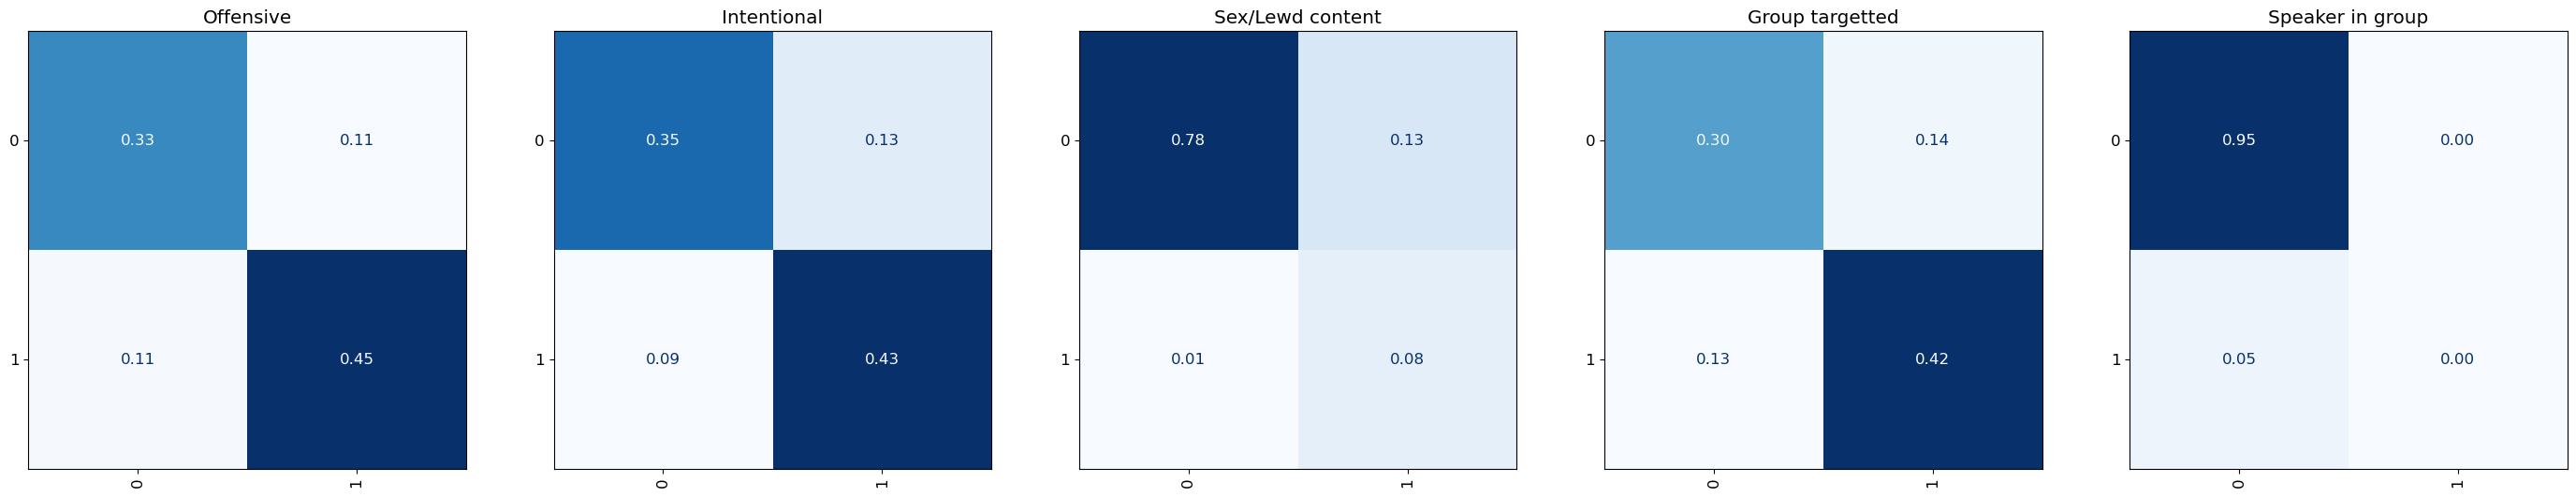

									 Default loss results
Offensive: 0.803
Intentional: 0.776
Sex/Lewd content: 0.198
Group targetted: 0.750
Speaker in group: 0.000


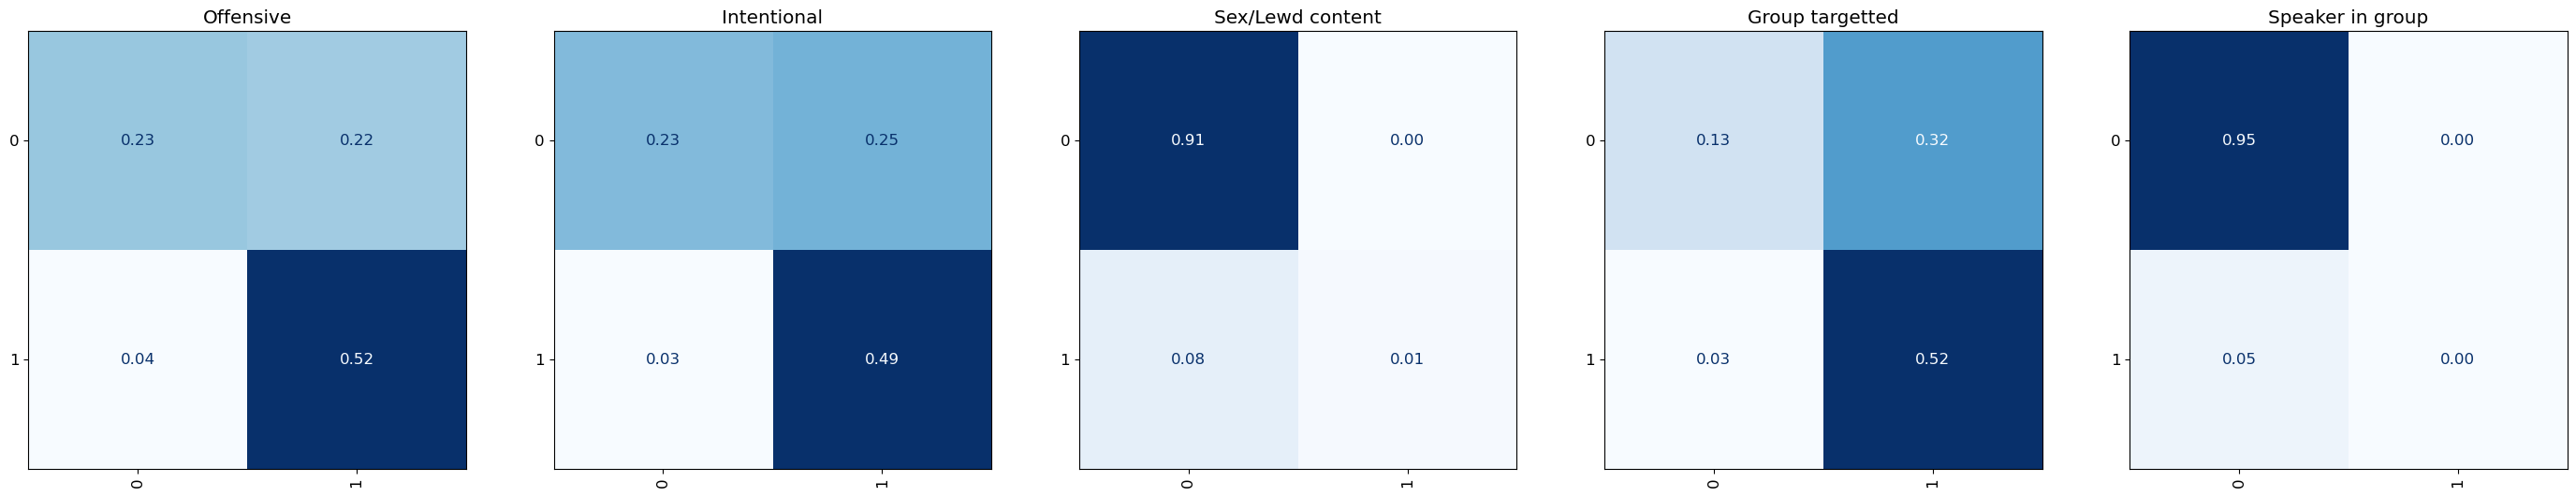

In [7]:
cls_labels = np.asarray(predictions_weight['labels']).T
cls_preds = np.asarray(predictions_weight['cls_preds']).T

print('\t'*8,'Weighted CrossEntropy loss results')
results_weight = evaluate_classification(cls_labels, cls_preds, config.classification_columns)
print_classification_results(cls_labels, cls_preds, results_weight)

cls_labels = np.asarray(predictions_no_weight['labels']).T
cls_preds = np.asarray(predictions_no_weight['cls_preds']).T

print('\t'*9,'Default loss results')
results_no_weight = evaluate_classification(cls_labels, cls_preds, config.classification_columns)
print_classification_results(cls_labels, cls_preds, results_no_weight)

As you can see, using the weights, we don't notice any decreasing on the classification scores, while we increase a lot the score of the sex feature. The in group speker, due to its havy unbalance, still impoossible to predict.

In [5]:
predictions_weight = evaluate_generation(predictions_weight, config)
group_rouge_score = [max(scores['rouge']) for scores in predictions_weight['group_scores'] if scores['rouge'] != None]
group_bleu_score = [max(scores['bleu']) for scores in predictions_weight['group_scores'] if scores['bleu'] != None]
group_wmd_score = [min(scores['wmd']) for scores in predictions_weight['stereotype_scores'] if scores['bleu'] != None]
stereotype_rouge_score = [max(scores['rouge']) for scores in predictions_weight['stereotype_scores'] if scores['rouge'] != None]
stereotype_bleu_score = [max(scores['bleu']) for scores in predictions_weight['stereotype_scores'] if scores['bleu'] != None]
stereotype_wmd_score = [min(scores['wmd']) for scores in predictions_weight['stereotype_scores'] if scores['bleu'] != None]

print('\t'*7,'Weighted CrossEntropy loss results')
print('Group scores:')
print(f'- Rouge-L F1:\t{np.mean(group_rouge_score):.3f}')
print(f'- BLEU-2:\t{np.mean(group_bleu_score):.3f}')
print(f'- WMD:\t{np.mean(group_wmd_score):.3f}')
print('Stereotype scores:')
print(f'- Rouge-L F1:\t{np.mean(stereotype_rouge_score):.3f}')
print(f'- BLEU-2:\t{np.mean(stereotype_bleu_score):.3f}')
print(f'- WMD:\t{np.mean(stereotype_wmd_score):.3f}')


predictions_no_weight = evaluate_generation(predictions_no_weight, config)
group_rouge_score = [max(scores['rouge']) for scores in predictions_no_weight['group_scores'] if scores['rouge'] != None]
group_bleu_score = [max(scores['bleu']) for scores in predictions_no_weight['group_scores'] if scores['bleu'] != None]
group_wmd_score = [min(scores['wmd']) for scores in predictions_weight['stereotype_scores'] if scores['bleu'] != None]
stereotype_rouge_score = [max(scores['rouge']) for scores in predictions_no_weight['stereotype_scores'] if scores['rouge'] != None]
stereotype_bleu_score = [max(scores['bleu']) for scores in predictions_no_weight['stereotype_scores'] if scores['bleu'] != None]
stereotype_wmd_score = [min(scores['wmd']) for scores in predictions_weight['stereotype_scores'] if scores['bleu'] != None]


print('\t'*8,'Default loss results')
print('Group scores:')
print(f'- Rouge-L F1:\t{np.mean(group_rouge_score):.3f}')
print(f'- BLEU-2:\t{np.mean(group_bleu_score):.3f}')
print(f'- WMD:\t{np.mean(group_wmd_score):.3f}')
print('Stereotype scores:')
print(f'- Rouge-L F1:\t{np.mean(stereotype_rouge_score):.3f}')
print(f'- BLEU-2:\t{np.mean(stereotype_bleu_score):.3f}')
print(f'- WMD:\t{np.mean(stereotype_wmd_score):.3f}')

INFO:gensim.models.keyedvectors:loading projection weights from wmd/word2vec-google-news-300.gz


INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from wmd/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-12-23T13:17:21.490727', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-91-generic-x86_64-with-glibc2.31', 'event': 'load_word2vec_format'}


: 

Moreover, we check the score obtained on the targetted group and on the stereotype, comparing the model trained with the weighted loss, with the default one. As before, between the two we don't see many difference. 

This two results, motivated us in using the weighted loss and since now all the GPT2 models was finetuned with it. Now, let's average the three seed results. 

In [5]:
stop_words = set(stopwords.words('english'))    
word_vectors = KeyedVectors.load_word2vec_format(config.wmd_model, binary=True)

INFO:gensim.models.keyedvectors:loading projection weights from wmd/word2vec-google-news-300.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from wmd/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-12-23T13:24:07.495546', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-91-generic-x86_64-with-glibc2.31', 'event': 'load_word2vec_format'}


In [21]:
predictions_weight[4553]

{'post': "you know what they say about glass houses . <repeat> niggers ca n't break in through the ceiling .",
 'group': ['black people'],
 'stereotype': ["black folks can't advance",
  'black folks are kept down',
  "black people can't hold high jobs",
  'black people are stuck in the lower class',
  'blacks are a criminals',
  'blacks cant hold a job'],
 'source': ['r/meanjokes'],
 'cls_preds': [1, 1, 0, 1, 0],
 'group_preds': 'black people',
 'stereotype_preds': 'black people are criminals',
 'labels': [1, 1, 0, 1, 0]}

In [27]:
def _preprocess_text_for_wmd(text):
    print(text)
    tokens = [token for token in text.split(" ") if token not in stop_words]
    print(tokens)
    return tokens


def compute_wmd(data):
    return {'wmd': [
        word_vectors.wmdistance(
            _preprocess_text_for_wmd(data['group_preds']),
            _preprocess_text_for_wmd(lbl)
        ) for lbl in data['group'] if lbl is not None 
    ] }


compute_wmd(predictions_weight[4553])

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:built Dictionary<2 unique tokens: ['black', 'people']> from 2 documents (total 4 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary<2 unique tokens: ['black', 'people']> from 2 documents (total 4 corpus positions)", 'datetime': '2023-12-23T13:29:32.554233', 'gensim': '4.3.2', 'python': '3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]', 'platform': 'Linux-5.15.0-91-generic-x86_64-with-glibc2.31', 'event': 'created'}


black people
['black', 'people']
black people
['black', 'people']


{'wmd': [0.0]}